In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import os
from matplotlib import pyplot as plt

from utils.data import subsampling
from utils.file import load_from_json

import time
from utils.model import load_lenet
from utils.metrics import error_rate
from attacks.attack import generate

Using TensorFlow backend.
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\t

In [2]:
from utils.model import load_pool
from utils.metrics import error_rate, get_corrections
from models.athena import Ensemble, ENSEMBLE_STRATEGY

def evaluate(trans_configs, model_configs,
             data_configs, task_aes, save=False, output_dir=None):
    """
    Apply transformation(s) on images.
    :param trans_configs: dictionary. The collection of the parameterized transformations to test.
        in the form of
        { configsx: {
            param: value,
            }
        }
        The key of a configuration is 'configs'x, where 'x' is the id of corresponding weak defense.
    :param model_configs:  dictionary. Defines model related information.
        Such as, location, the undefended model, the file format, etc.
    :param data_configs: dictionary. Defines data related information.
        Such as, location, the file for the true labels, the file for the benign samples,
        the files for the adversarial examples, etc.
    :param save: boolean. Save the transformed sample or not.
    :param output_dir: path or str. The location to store the transformed samples.
        It cannot be None when save is True.
    :return:
    """
    # Load the baseline defense (PGD-ADT model)
    baseline = load_lenet(file=model_configs.get('pgd_trained'), trans_configs=None,
                                  use_logits=False, wrap=False)

    # get the undefended model (UM)
    file = os.path.join(model_configs.get('dir'), model_configs.get('um_file'))
    undefended = load_lenet(file=file,
                            trans_configs=trans_configs.get('configs0'),
                            wrap=True)
    print(">>> um:", type(undefended))

    # load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    # create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    print(">>> wds:", type(wds), type(wds[0]))
    ensemble = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

    # load the benign samples
    bs_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
    x_bs = np.load(bs_file)
    img_rows, img_cols = x_bs.shape[1], x_bs.shape[2]

    # load the corresponding true labels
    label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
    labels = np.load(label_file)

    # get indices of benign samples that are correctly classified by the targeted model
    print(">>> Evaluating UM on [{}], it may take a while...".format(bs_file))
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)

    # Evaluate AEs.
    results = {}
    eval_result = {}
    #ae_list = data_configs.get('ae_files')
    ae_list = data_configs.get(task_aes)
    
    for ae in ae_list:
        ae_file = os.path.join(data_configs.get('dir'), ae)
#         print(type(ae_file))
#         print(ae_file)
        #print(ae_list[4])
        x_adv = np.load(ae_file)

        # evaluate the undefended model on the AE
        print(">>> Evaluating UM on [{}], it may take a while...".format(ae_file))
        pred_adv_um = undefended.predict(x_adv)
        err_um = error_rate(y_pred=pred_adv_um, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['UM'] = err_um
        if 'UM' not in eval_result:
            eval_result['UM'] = [err_um]
        else:
            eval_result['UM'].append(err_um)

        # evaluate the ensemble on the AE
        print(">>> Evaluating ensemble on [{}], it may take a while...".format(ae_file))
        pred_adv_ens = ensemble.predict(x_adv)
        err_ens = error_rate(y_pred=pred_adv_ens, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['Ensemble'] = err_ens
        if 'Ensemble' not in eval_result:
            eval_result['Ensemble'] = [err_ens]
        else:
            eval_result['Ensemble'].append(err_ens)

        # evaluate the baseline on the AE
        print(">>> Evaluating baseline model on [{}], it may take a while...".format(ae_file))
        pred_adv_bl = baseline.predict(x_adv)
        err_bl = error_rate(y_pred=pred_adv_bl, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['PGD-ADT'] = err_bl
        if 'PGD-ADT' not in eval_result:
            eval_result['PGD-ADT'] = [err_bl]
        else:
            eval_result['PGD-ADT'].append(err_bl)

        # TODO: collect and dump the evaluation results to file(s) such that you can analyze them later.
        print(">>> Evaluations on [{}]:\n{}".format(ae_file, results))
    print(eval_result)
    return eval_result

## Evaluating AEs using 20 WDs with AVEP

In [3]:
# load experiment configurations
trans_configs = load_from_json("../src/configs/demo/athena-mnist.json")
model_configs = load_from_json("../src/configs/demo/model-mnist.json")
data_configs = load_from_json("../src/configs/demo/data-mnist.json")

output_root = "../ae_results"

# evaluate task-2 aes
task2_eval_20AVEP = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task2_aes',
         output_dir=output_root)

# evaluate task-1 aes for comparison
task1_eval_20AVEP = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task1_aes',
         output_dir=output_root)

# evaluate task-1 aes for comparison
baseline_aes_eval_20AVEP = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'ae_files',
         output_dir=output_root)

>>> Loading model [../models/baseline/advTrained-mnist-adtC.h5]...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
>>> Loading model [../models/cnn/model-mnist-cnn-clean.h5]...
>>> um: <class 'models.keraswrapper.WeakDefense'>
>>> Loading model [../models/cnn/model-mnist-cnn-rotate90.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_top_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_horizontal_compress.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-morph_gradient.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_mean_type3.h5]...
>>> Loading model [../models/cnn/model-mnist-cn

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


>>> Evaluating baseline model on [../data/FGSM_eps0.08_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.08_rot_Task2.npy]:
{'UM': 0.01314459049544995, 'Ensemble': 0.00910010111223458, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...
>>> Evaluating baseline model on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.15_rot_Task2.npy]:
{'UM': 0.030333670374115267, 'Ensemble': 0.023255813953488372, 'PGD-ADT': 0.016177957532861477}
>>> Evaluating UM on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...
>>> Evaluating baseline model on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.20_rot_Task2.npy]:
{'UM': 0.073811931

>>> Evaluating ensemble on [../data/PGD_eps0.20_tran_100_Task2.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.20_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.20_tran_100_Task2.npy]:
{'UM': 0.024266936299292215, 'Ensemble': 0.017189079878665317, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_tran_100_Task2.npy]:
{'UM': 0.042467138523761376, 'Ensemble': 0.027300303336703743, 'PGD-ADT': 0.01314459049544995}
>>> Evaluating UM on [../data/PGD_eps0.30_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_tran_100_Task2.npy], it may take a while...
>>> Evaluating baseline model on [../data/PG

>>> Evaluating ensemble on [../data/PGD_eps0.20_Veps_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.20_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.20_Veps_task1.npy]:
{'UM': 0.9858442871587462, 'Ensemble': 0.046511627906976744, 'PGD-ADT': 0.055611729019211326}
>>> Evaluating UM on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_Veps_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.07280080889787664, 'PGD-ADT': 0.10414560161779575}
>>> Evaluating UM on [../data/PGD_eps0.30_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_Veps_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.30_Veps_task1.npy], it may take a

>>> Evaluating ensemble on [../data/BIM_eps0.30_max_iter_60_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/BIM_eps0.30_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.30_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.40546006066734075, 'PGD-ADT': 0.3640040444893832}
>>> Evaluating UM on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.40_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.698685540950455, 'PGD-ADT': 0.80788675429727}
>>> Evaluating UM on [../data/BIM_eps0.08_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.08_max_iter_100_task1.npy], it may take a while...
>>> Evaluating baseline mod

>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy]:
{'UM': 0.8918099089989889, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9049544994944388}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy]:
{'UM': 0.8938321536905965, 'Ensemble': 0.9069767441860465, 'PGD-ADT': 0.9039433771486349}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy]:

>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-cw_l2_lr0.018.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-cw_l2_lr0.018.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-cw_l2_lr0.018.npy]:
{'UM': 0.8867542972699697, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-deepfool_l2_overshoot3.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-deepfool_l2_overshoot3.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-deepfool_l2_overshoot3.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-deepfool_l2_overshoot3.npy]:
{'UM': 0.8988877654196158, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9009100101112234}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-deepfool_l2_overshoot5.npy], it may take a while...
>>> Evaluatin

>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-mim_eps0.067.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-mim_eps0.067.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-mim_eps0.067.npy]:
{'UM': 0.8918099089989889, 'Ensemble': 0.9069767441860465, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-mim_eps0.075.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-mim_eps0.075.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-mim_eps0.075.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-mim_eps0.075.npy]:
{'UM': 0.8968655207280081, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-mim_eps0.085.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-mim_ep

## Using Majority Voting Ensemble Strategy with the 20 WDs

In [4]:
from utils.model import load_pool
from utils.metrics import error_rate, get_corrections
from models.athena import Ensemble, ENSEMBLE_STRATEGY

def evaluate(trans_configs, model_configs,
             data_configs, task_aes, save=False, output_dir=None):
    """
    Apply transformation(s) on images.
    :param trans_configs: dictionary. The collection of the parameterized transformations to test.
        in the form of
        { configsx: {
            param: value,
            }
        }
        The key of a configuration is 'configs'x, where 'x' is the id of corresponding weak defense.
    :param model_configs:  dictionary. Defines model related information.
        Such as, location, the undefended model, the file format, etc.
    :param data_configs: dictionary. Defines data related information.
        Such as, location, the file for the true labels, the file for the benign samples,
        the files for the adversarial examples, etc.
    :param save: boolean. Save the transformed sample or not.
    :param output_dir: path or str. The location to store the transformed samples.
        It cannot be None when save is True.
    :return:
    """
    # Load the baseline defense (PGD-ADT model)
    baseline = load_lenet(file=model_configs.get('pgd_trained'), trans_configs=None,
                                  use_logits=False, wrap=False)

    # get the undefended model (UM)
    file = os.path.join(model_configs.get('dir'), model_configs.get('um_file'))
    undefended = load_lenet(file=file,
                            trans_configs=trans_configs.get('configs0'),
                            wrap=True)
    print(">>> um:", type(undefended))

    # load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    # create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    print(">>> wds:", type(wds), type(wds[0]))
    ensemble = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.MV.value)

    # load the benign samples
    bs_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
    x_bs = np.load(bs_file)
    img_rows, img_cols = x_bs.shape[1], x_bs.shape[2]

    # load the corresponding true labels
    label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
    labels = np.load(label_file)

    # get indices of benign samples that are correctly classified by the targeted model
    print(">>> Evaluating UM on [{}], it may take a while...".format(bs_file))
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)

    # Evaluate AEs.
    results = {}
    eval_result = {}
    #ae_list = data_configs.get('ae_files')
    ae_list = data_configs.get(task_aes)
    
    for ae in ae_list:
        ae_file = os.path.join(data_configs.get('dir'), ae)
#         print(type(ae_file))
#         print(ae_file)
        #print(ae_list[4])
        x_adv = np.load(ae_file)

        # evaluate the undefended model on the AE
        print(">>> Evaluating UM on [{}], it may take a while...".format(ae_file))
        pred_adv_um = undefended.predict(x_adv)
        err_um = error_rate(y_pred=pred_adv_um, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['UM'] = err_um
        if 'UM' not in eval_result:
            eval_result['UM'] = [err_um]
        else:
            eval_result['UM'].append(err_um)

        # evaluate the ensemble on the AE
        print(">>> Evaluating ensemble on [{}], it may take a while...".format(ae_file))
        pred_adv_ens = ensemble.predict(x_adv)
        err_ens = error_rate(y_pred=pred_adv_ens, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['Ensemble'] = err_ens
        if 'Ensemble' not in eval_result:
            eval_result['Ensemble'] = [err_ens]
        else:
            eval_result['Ensemble'].append(err_ens)

        # evaluate the baseline on the AE
        print(">>> Evaluating baseline model on [{}], it may take a while...".format(ae_file))
        pred_adv_bl = baseline.predict(x_adv)
        err_bl = error_rate(y_pred=pred_adv_bl, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['PGD-ADT'] = err_bl
        if 'PGD-ADT' not in eval_result:
            eval_result['PGD-ADT'] = [err_bl]
        else:
            eval_result['PGD-ADT'].append(err_bl)

        # TODO: collect and dump the evaluation results to file(s) such that you can analyze them later.
        print(">>> Evaluations on [{}]:\n{}".format(ae_file, results))
    print(eval_result)
    return eval_result

In [5]:
# load experiment configurations
trans_configs = load_from_json("../src/configs/demo/athena-mnist.json")
model_configs = load_from_json("../src/configs/demo/model-mnist.json")
data_configs = load_from_json("../src/configs/demo/data-mnist.json")

output_root = "../ae_results"

# evaluate task-2 aes
task2_eval_20MV = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task2_aes',
         output_dir=output_root)

# evaluate task-1 aes for comparison
task1_eval_20MV = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task1_aes',
         output_dir=output_root)

# evaluate task-1 aes for comparison
baseline_aes_eval_20MV = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'ae_files',
         output_dir=output_root)

>>> Loading model [../models/baseline/advTrained-mnist-adtC.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-clean.h5]...
>>> um: <class 'models.keraswrapper.WeakDefense'>
>>> Loading model [../models/cnn/model-mnist-cnn-rotate90.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_top_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_horizontal_compress.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-morph_gradient.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_mean_type3.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_gaussian_type4.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-distort_y.h5]...
>>> Loading model [../

>>> Evaluating ensemble on [../data/PGD_eps0.25_tran_50_Task2.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.25_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_tran_50_Task2.npy]:
{'UM': 0.033367037411526794, 'Ensemble': 0.020222446916076844, 'PGD-ADT': 0.01314459049544995}
>>> Evaluating UM on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_tran_50_Task2.npy]:
{'UM': 0.047522750252780584, 'Ensemble': 0.030333670374115267, 'PGD-ADT': 0.01820020222446916}
>>> Evaluating UM on [../data/PGD_eps0.40_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.40_tran_50_Task2.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.40

>>> Evaluations on [../data/FGSM_eps0.20_task1.npy]:
{'UM': 0.717896865520728, 'Ensemble': 0.05358948432760364, 'PGD-ADT': 0.05358948432760364}
>>> Evaluating UM on [../data/FGSM_eps0.25_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.25_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/FGSM_eps0.25_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.25_task1.npy]:
{'UM': 0.8291203235591507, 'Ensemble': 0.13144590495449948, 'PGD-ADT': 0.10616784630940344}
>>> Evaluating UM on [../data/FGSM_eps0.30_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.30_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/FGSM_eps0.30_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.30_task1.npy]:
{'UM': 0.8796764408493428, 'Ensemble': 0.34074823053589487, 'PGD-ADT': 0.19716885743174925}
>>> Evaluating UM on [../data/FGSM_eps0.40_task1.npy], it may 

>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_20_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_20_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_20_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.30940343781597573, 'PGD-ADT': 0.301314459049545}
>>> Evaluating UM on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...
>>> Evaluating baseline model on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.08_max_iter_60_task1.npy]:
{'UM': 0.6703741152679474, 'Ensemble': 0.012133468149646108, 'PGD-ADT': 0.016177957532861477}
>>> Evaluating UM on [../data/BIM_eps0.15_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.15_max_iter_60_task1.npy], it may take a while...
>>> Evaluating baseline

>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_horizontal_compress.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-morph_gradient.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_mean_type3.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_gaussian_type4.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-distort_y.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-noise_salt.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-filter_gaussian.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-filter_median.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-filter_entropy.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-compress_jpeg_quality_80.h5]...
>>> Loading model [../models/cnn/model-mnis

>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.12.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.12.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.12.npy]:
{'UM': 0.8827098078867543, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9039433771486349}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-cw_l2_lr0.0098.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-cw_l2_lr0.0098.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-cw_l2_lr0.0098.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-cw_l2_lr0.0098.npy]:
{'UM': 0.8837209302325582, 'Ensemble': 0.9049544994944388, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-cw_l2_lr0.01.npy], it may take a while...
>>> Evaluating ensemble on [../data/test

>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy]:
{'UM': 0.8958543983822043, 'Ensemble': 0.9049544994944388, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy]:
{'UM': 0.8867542972699697, 'Ensemble': 0.9049544994944388, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.n

# Evaluation Using 40 WDs


In [14]:
from utils.model import load_pool
from utils.metrics import error_rate, get_corrections
from models.athena import Ensemble, ENSEMBLE_STRATEGY

def evaluate(trans_configs, model_configs,
             data_configs, task_aes, save=False, output_dir=None):
    """
    Apply transformation(s) on images.
    :param trans_configs: dictionary. The collection of the parameterized transformations to test.
        in the form of
        { configsx: {
            param: value,
            }
        }
        The key of a configuration is 'configs'x, where 'x' is the id of corresponding weak defense.
    :param model_configs:  dictionary. Defines model related information.
        Such as, location, the undefended model, the file format, etc.
    :param data_configs: dictionary. Defines data related information.
        Such as, location, the file for the true labels, the file for the benign samples,
        the files for the adversarial examples, etc.
    :param save: boolean. Save the transformed sample or not.
    :param output_dir: path or str. The location to store the transformed samples.
        It cannot be None when save is True.
    :return:
    """
    # Load the baseline defense (PGD-ADT model)
    baseline = load_lenet(file=model_configs.get('pgd_trained'), trans_configs=None,
                                  use_logits=False, wrap=False)

    # get the undefended model (UM)
    file = os.path.join(model_configs.get('dir'), model_configs.get('um_file'))
    undefended = load_lenet(file=file,
                            trans_configs=trans_configs.get('configs0'),
                            wrap=True)
    print(">>> um:", type(undefended))

    # load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    # create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    print(">>> wds:", type(wds), type(wds[0]))
    ensemble = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

    # load the benign samples
    bs_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
    x_bs = np.load(bs_file)
    img_rows, img_cols = x_bs.shape[1], x_bs.shape[2]

    # load the corresponding true labels
    label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
    labels = np.load(label_file)

    # get indices of benign samples that are correctly classified by the targeted model
    print(">>> Evaluating UM on [{}], it may take a while...".format(bs_file))
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)

    # Evaluate AEs.
    results = {}
    eval_result = {}
    #ae_list = data_configs.get('ae_files')
    ae_list = data_configs.get(task_aes)
    
    for ae in ae_list:
        ae_file = os.path.join(data_configs.get('dir'), ae)
#         print(type(ae_file))
#         print(ae_file)
        #print(ae_list[4])
        x_adv = np.load(ae_file)

        # evaluate the undefended model on the AE
        print(">>> Evaluating UM on [{}], it may take a while...".format(ae_file))
        pred_adv_um = undefended.predict(x_adv)
        err_um = error_rate(y_pred=pred_adv_um, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['UM'] = err_um
        if 'UM' not in eval_result:
            eval_result['UM'] = [err_um]
        else:
            eval_result['UM'].append(err_um)

        # evaluate the ensemble on the AE
        print(">>> Evaluating ensemble on [{}], it may take a while...".format(ae_file))
        pred_adv_ens = ensemble.predict(x_adv)
        err_ens = error_rate(y_pred=pred_adv_ens, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['Ensemble'] = err_ens
        if 'Ensemble' not in eval_result:
            eval_result['Ensemble'] = [err_ens]
        else:
            eval_result['Ensemble'].append(err_ens)

        # evaluate the baseline on the AE
        print(">>> Evaluating baseline model on [{}], it may take a while...".format(ae_file))
        pred_adv_bl = baseline.predict(x_adv)
        err_bl = error_rate(y_pred=pred_adv_bl, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['PGD-ADT'] = err_bl
        if 'PGD-ADT' not in eval_result:
            eval_result['PGD-ADT'] = [err_bl]
        else:
            eval_result['PGD-ADT'].append(err_bl)

        # TODO: collect and dump the evaluation results to file(s) such that you can analyze them later.
        print(">>> Evaluations on [{}]:\n{}".format(ae_file, results))
    print(eval_result)
    return eval_result

In [15]:
# load experiment configurations
trans_configs = load_from_json("../src/configs/demo/athena-mnist.json")
model_configs = load_from_json("../src/configs/demo/model-mnist.json")
data_configs = load_from_json("../src/configs/demo/data-mnist.json")

output_root = "../ae_results"


# evaluate task-1 aes for comparison
baseline_aes_eval_40AVEP = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'ae_files',
         output_dir=output_root)

# evaluate task-2 aes
task2_eval_40AVEP = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task2_aes',
         output_dir=output_root)

# evaluate task-1 aes for comparison
task1_eval_40AVEP = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task1_aes',
         output_dir=output_root)

>>> Loading model [../models/baseline/advTrained-mnist-adtC.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-clean.h5]...
>>> um: <class 'models.keraswrapper.WeakDefense'>
>>> Loading model [../models/cnn/model-mnist-cnn-rotate90.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-rotate270.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_right.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_up.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_top_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_both.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_vertical_compress.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_vertical_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-c

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.1.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.1.npy]:
{'UM': 0.8998988877654196, 'Ensemble': 0.9069767441860465, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy]:
{'UM': 0.8918099089989889, 'Ensemble': 0.9079878665318504, 'PGD-ADT': 0.9049544994944388}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy]:
{'UM': 0.8938321536905965, 'Ensemble': 0.9069767441860465, 'PGD-ADT': 0.9039433771486349}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy]:
{'UM': 0.884732052578362, 'Ensemble': 0.9069767441860465, 'PGD-ADT': 0.9009100101112234}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy]:
{'UM': 0.884732052578362, 'Ensemble': 0.890798786653185, 'PGD-ADT': 0.8928210313447927}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy]:
{'UM': 0.8968655207280081, 'Ensemble': 0.9049544994944388, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy]:
{'UM': 0.8958543983822043, 'Ensemble': 0.9039433771486349, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy]:
{'UM': 0.8867542972699697, 'Ensemble': 0.9049544994944388, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy]:
{'UM': 0.8958543983822043, 'Ensemble': 0.9069767441860465, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.11.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.11.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.11.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.11.npy]:
{'UM': 0.8928210313447927, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9039433771486349}
{'UM': [0.8998988877654196, 0.8918099089989889, 0.8938321536905965, 0.884732052578362, 0.884732052578362, 0.8968655207280081, 0.8958543983822043, 0.8867542972699697, 0.8958543983822043, 0.8928210313447927], 'Ensemble': [0.9069767441860465, 0.9079878665318504, 0.9069767441860465, 0.9069767441860465, 0.890798786653185, 0.9049544994944388, 0.9039433771486349, 0.9049544994944388, 0.9069767441860465, 0.9059656218402427], 'PGD-ADT': [0.9019211324570273, 0.9049544994944388, 0.9039433771486349, 0.9009100101112234, 0.8928210313447927, 0.9019211324570273, 0.9019211324570273, 0.9029322548028311, 0.9029322548028311, 0.9039433771486349]}
>>> Loading model [../models/baseline/advTrained-mnist-adtC.h5]...
>>> Loading model [../models/cnn/

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.08_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.08_rot_Task2.npy]:
{'UM': 0.01314459049544995, 'Ensemble': 0.008088978766430738, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.15_rot_Task2.npy]:
{'UM': 0.030333670374115267, 'Ensemble': 0.019211324570273004, 'PGD-ADT': 0.016177957532861477}
>>> Evaluating UM on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.20_rot_Task2.npy]:
{'UM': 0.07381193124368049, 'Ensemble': 0.029322548028311426, 'PGD-ADT': 0.027300303336703743}
>>> Evaluating UM on [../data/FGSM_eps0.25_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.25_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.25_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.25_rot_Task2.npy]:
{'UM': 0.21638018200202225, 'Ensemble': 0.06774519716885744, 'PGD-ADT': 0.03842264914054601}
>>> Evaluating UM on [../data/FGSM_eps0.30_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.30_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.30_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.30_rot_Task2.npy]:
{'UM': 0.4408493427704752, 'Ensemble': 0.1769464105156724, 'PGD-ADT': 0.07684529828109202}
>>> Evaluating UM on [../data/FGSM_eps0.40_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.40_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.40_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.40_rot_Task2.npy]:
{'UM': 0.8119312436804853, 'Ensemble': 0.6238624873609707, 'PGD-ADT': 0.42972699696663297}
>>> Evaluating UM on [../data/FGSM_eps0.08_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.08_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.08_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.08_tran_Task2.npy]:
{'UM': 0.006066734074823054, 'Ensemble': 0.005055611729019211, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/FGSM_eps0.15_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.15_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.15_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.15_tran_Task2.npy]:
{'UM': 0.021233569261880688, 'Ensemble': 0.010111223458038422, 'PGD-ADT': 0.011122345803842264}
>>> Evaluating UM on [../data/FGSM_eps0.20_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.20_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.20_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.20_tran_Task2.npy]:
{'UM': 0.056622851365015166, 'Ensemble': 0.017189079878665317, 'PGD-ADT': 0.015166835187057633}
>>> Evaluating UM on [../data/FGSM_eps0.25_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.25_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.25_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.25_tran_Task2.npy]:
{'UM': 0.18099089989888775, 'Ensemble': 0.03943377148634985, 'PGD-ADT': 0.022244691607684528}
>>> Evaluating UM on [../data/FGSM_eps0.30_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.30_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.30_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.30_tran_Task2.npy]:
{'UM': 0.40141557128412536, 'Ensemble': 0.1102123356926188, 'PGD-ADT': 0.0525783619817998}
>>> Evaluating UM on [../data/FGSM_eps0.40_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.40_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.40_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.40_tran_Task2.npy]:
{'UM': 0.7785642062689585, 'Ensemble': 0.49342770475227504, 'PGD-ADT': 0.3488372093023256}
>>> Evaluating UM on [../data/PGD_eps0.08_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.08_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.08_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.08_tran_50_Task2.npy]:
{'UM': 0.0010111223458038423, 'Ensemble': 0.004044489383215369, 'PGD-ADT': 0.008088978766430738}
>>> Evaluating UM on [../data/PGD_eps0.15_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.15_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.15_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.15_tran_50_Task2.npy]:
{'UM': 0.00910010111223458, 'Ensemble': 0.008088978766430738, 'PGD-ADT': 0.012133468149646108}
>>> Evaluating UM on [../data/PGD_eps0.20_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.20_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.20_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.20_tran_50_Task2.npy]:
{'UM': 0.020222446916076844, 'Ensemble': 0.01314459049544995, 'PGD-ADT': 0.011122345803842264}
>>> Evaluating UM on [../data/PGD_eps0.25_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.25_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.25_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_tran_50_Task2.npy]:
{'UM': 0.033367037411526794, 'Ensemble': 0.017189079878665317, 'PGD-ADT': 0.01314459049544995}
>>> Evaluating UM on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_tran_50_Task2.npy]:
{'UM': 0.047522750252780584, 'Ensemble': 0.025278058645096056, 'PGD-ADT': 0.01820020222446916}
>>> Evaluating UM on [../data/PGD_eps0.40_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.40_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.40_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.40_tran_50_Task2.npy]:
{'UM': 0.11830131445904954, 'Ensemble': 0.055611729019211326, 'PGD-ADT': 0.032355915065722954}
>>> Evaluating UM on [../data/PGD_eps0.08_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.08_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.08_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.08_tran_100_Task2.npy]:
{'UM': 0.003033367037411527, 'Ensemble': 0.004044489383215369, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/PGD_eps0.15_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.15_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.15_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.15_tran_100_Task2.npy]:
{'UM': 0.017189079878665317, 'Ensemble': 0.00910010111223458, 'PGD-ADT': 0.010111223458038422}
>>> Evaluating UM on [../data/PGD_eps0.20_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.20_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.20_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.20_tran_100_Task2.npy]:
{'UM': 0.024266936299292215, 'Ensemble': 0.015166835187057633, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_tran_100_Task2.npy]:
{'UM': 0.042467138523761376, 'Ensemble': 0.020222446916076844, 'PGD-ADT': 0.01314459049544995}
>>> Evaluating UM on [../data/PGD_eps0.30_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_tran_100_Task2.npy]:
{'UM': 0.07987866531850354, 'Ensemble': 0.03538928210313448, 'PGD-ADT': 0.020222446916076844}
>>> Evaluating UM on [../data/PGD_eps0.40_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.40_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.40_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.40_tran_100_Task2.npy]:
{'UM': 0.20525783619817997, 'Ensemble': 0.1051567239635996, 'PGD-ADT': 0.05358948432760364}
{'UM': [0.01314459049544995, 0.030333670374115267, 0.07381193124368049, 0.21638018200202225, 0.4408493427704752, 0.8119312436804853, 0.006066734074823054, 0.021233569261880688, 0.056622851365015166, 0.18099089989888775, 0.40141557128412536, 0.7785642062689585, 0.0010111223458038423, 0.00910010111223458, 0.020222446916076844, 0.033367037411526794, 0.047522750252780584, 0.11830131445904954, 0.003033367037411527, 0.017189079878665317, 0.024266936299292215, 0.042467138523761376, 0.07987866531850354, 0.20525783619817997], 'Ensemble': [0.008088978766430738, 0.019211324570273004, 0.029322548028311426, 0.06774519716885744, 0.1769464105156724, 0.6238624873609707, 0.005055611729019211, 0.010111223458038422, 0.017189079878665317, 0.03943377148634985,

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.08_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.08_task1.npy]:
{'UM': 0.16683518705763398, 'Ensemble': 0.010111223458038422, 'PGD-ADT': 0.015166835187057633}
>>> Evaluating UM on [../data/FGSM_eps0.15_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.15_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.15_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.15_task1.npy]:
{'UM': 0.5005055611729019, 'Ensemble': 0.021233569261880688, 'PGD-ADT': 0.03741152679474216}
>>> Evaluating UM on [../data/FGSM_eps0.20_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.20_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.20_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.20_task1.npy]:
{'UM': 0.717896865520728, 'Ensemble': 0.03741152679474216, 'PGD-ADT': 0.05358948432760364}
>>> Evaluating UM on [../data/FGSM_eps0.25_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.25_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.25_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.25_task1.npy]:
{'UM': 0.8291203235591507, 'Ensemble': 0.10313447927199192, 'PGD-ADT': 0.10616784630940344}
>>> Evaluating UM on [../data/FGSM_eps0.30_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.30_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.30_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.30_task1.npy]:
{'UM': 0.8796764408493428, 'Ensemble': 0.27098078867542974, 'PGD-ADT': 0.19716885743174925}
>>> Evaluating UM on [../data/FGSM_eps0.40_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.40_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.40_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.40_task1.npy]:
{'UM': 0.9069767441860465, 'Ensemble': 0.7512639029322548, 'PGD-ADT': 0.6703741152679474}
>>> Evaluating UM on [../data/PGD_eps0.08_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.08_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.08_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.08_Veps_task1.npy]:
{'UM': 0.3862487360970677, 'Ensemble': 0.00910010111223458, 'PGD-ADT': 0.015166835187057633}
>>> Evaluating UM on [../data/PGD_eps0.15_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.15_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.15_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.15_Veps_task1.npy]:
{'UM': 0.9474216380182002, 'Ensemble': 0.023255813953488372, 'PGD-ADT': 0.03640040444893832}
>>> Evaluating UM on [../data/PGD_eps0.20_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.20_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.20_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.20_Veps_task1.npy]:
{'UM': 0.9858442871587462, 'Ensemble': 0.042467138523761376, 'PGD-ADT': 0.055611729019211326}
>>> Evaluating UM on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_Veps_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.07987866531850354, 'PGD-ADT': 0.10414560161779575}
>>> Evaluating UM on [../data/PGD_eps0.30_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_Veps_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.12537917087967643, 'PGD-ADT': 0.15874620829120323}
>>> Evaluating UM on [../data/PGD_eps0.40_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.40_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.40_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.40_Veps_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.3195146612740142, 'PGD-ADT': 0.39838220424671383}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.015_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.015_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.015_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.015_task1.npy]:
{'UM': 0.9474216380182002, 'Ensemble': 0.022244691607684528, 'PGD-ADT': 0.03640040444893832}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.02_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.02_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.02_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.02_task1.npy]:
{'UM': 0.9858442871587462, 'Ensemble': 0.041456016177957536, 'PGD-ADT': 0.055611729019211326}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.03_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.03_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.03_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.03_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.12740141557128412, 'PGD-ADT': 0.15874620829120323}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.06_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.06_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.06_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.06_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.2527805864509606, 'PGD-ADT': 0.27401415571284127}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.10_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.10_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.10_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.10_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.3306370070778564, 'PGD-ADT': 0.29625884732052576}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.15_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.15_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.15_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.15_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.3528816986855409, 'PGD-ADT': 0.2770475227502528}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_5_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_5_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_5_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_5_task1.npy]:
{'UM': 0.9059656218402427, 'Ensemble': 0.021233569261880688, 'PGD-ADT': 0.03741152679474216}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_7_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_7_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_7_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_7_task1.npy]:
{'UM': 0.9817997977755308, 'Ensemble': 0.05055611729019211, 'PGD-ADT': 0.05864509605662285}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_10_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_10_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_10_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_10_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.1263902932254803, 'PGD-ADT': 0.15874620829120323}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_15_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_15_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_15_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_15_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.20525783619817997, 'PGD-ADT': 0.2659251769464105}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_20_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_20_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_20_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_20_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.2517694641051567, 'PGD-ADT': 0.301314459049545}
>>> Evaluating UM on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.08_max_iter_60_task1.npy]:
{'UM': 0.6703741152679474, 'Ensemble': 0.012133468149646108, 'PGD-ADT': 0.016177957532861477}
>>> Evaluating UM on [../data/BIM_eps0.15_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.15_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.15_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.15_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.027300303336703743, 'PGD-ADT': 0.044489383215369056}
>>> Evaluating UM on [../data/BIM_eps0.20_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.20_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.20_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.20_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.06471183013144591, 'PGD-ADT': 0.07987866531850354}
>>> Evaluating UM on [../data/BIM_eps0.25_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.25_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.25_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.25_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.1557128412537917, 'PGD-ADT': 0.16582406471183014}
>>> Evaluating UM on [../data/BIM_eps0.30_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.30_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.30_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.30_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.3518705763397371, 'PGD-ADT': 0.3640040444893832}
>>> Evaluating UM on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.40_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.6865520728008089, 'PGD-ADT': 0.80788675429727}
>>> Evaluating UM on [../data/BIM_eps0.08_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.08_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.08_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.08_max_iter_100_task1.npy]:
{'UM': 0.6804853387259858, 'Ensemble': 0.011122345803842264, 'PGD-ADT': 0.016177957532861477}
>>> Evaluating UM on [../data/BIM_eps0.15_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.15_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.15_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.15_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.0262891809908999, 'PGD-ADT': 0.046511627906976744}
>>> Evaluating UM on [../data/BIM_eps0.20_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.20_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.20_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.20_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.06471183013144591, 'PGD-ADT': 0.07785642062689585}
>>> Evaluating UM on [../data/BIM_eps0.25_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.25_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.25_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.25_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.16177957532861476, 'PGD-ADT': 0.17290192113245703}
>>> Evaluating UM on [../data/BIM_eps0.30_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.30_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.30_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.30_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.3609706774519717, 'PGD-ADT': 0.3710819009100101}
>>> Evaluating UM on [../data/BIM_eps0.40_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.40_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.40_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.40_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.6956521739130435, 'PGD-ADT': 0.8220424671385238}
{'UM': [0.16683518705763398, 0.5005055611729019, 0.717896865520728, 0.8291203235591507, 0.8796764408493428, 0.9069767441860465, 0.3862487360970677, 0.9474216380182002, 0.9858442871587462, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9474216380182002, 0.9858442871587462, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9059656218402427, 0.9817997977755308, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.6703741152679474, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.6804853387259858, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577], 'Ensemble': [0.010111223458038422,

In [17]:
from utils.model import load_pool
from utils.metrics import error_rate, get_corrections
from models.athena import Ensemble, ENSEMBLE_STRATEGY

def evaluate(trans_configs, model_configs,
             data_configs, task_aes, save=False, output_dir=None):
    """
    Apply transformation(s) on images.
    :param trans_configs: dictionary. The collection of the parameterized transformations to test.
        in the form of
        { configsx: {
            param: value,
            }
        }
        The key of a configuration is 'configs'x, where 'x' is the id of corresponding weak defense.
    :param model_configs:  dictionary. Defines model related information.
        Such as, location, the undefended model, the file format, etc.
    :param data_configs: dictionary. Defines data related information.
        Such as, location, the file for the true labels, the file for the benign samples,
        the files for the adversarial examples, etc.
    :param save: boolean. Save the transformed sample or not.
    :param output_dir: path or str. The location to store the transformed samples.
        It cannot be None when save is True.
    :return:
    """
    # Load the baseline defense (PGD-ADT model)
    baseline = load_lenet(file=model_configs.get('pgd_trained'), trans_configs=None,
                                  use_logits=False, wrap=False)

    # get the undefended model (UM)
    file = os.path.join(model_configs.get('dir'), model_configs.get('um_file'))
    undefended = load_lenet(file=file,
                            trans_configs=trans_configs.get('configs0'),
                            wrap=True)
    print(">>> um:", type(undefended))

    # load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    # create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    print(">>> wds:", type(wds), type(wds[0]))
    ensemble = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.MV.value)

    # load the benign samples
    bs_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
    x_bs = np.load(bs_file)
    img_rows, img_cols = x_bs.shape[1], x_bs.shape[2]

    # load the corresponding true labels
    label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
    labels = np.load(label_file)

    # get indices of benign samples that are correctly classified by the targeted model
    print(">>> Evaluating UM on [{}], it may take a while...".format(bs_file))
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)

    # Evaluate AEs.
    results = {}
    eval_result = {}
    #ae_list = data_configs.get('ae_files')
    ae_list = data_configs.get(task_aes)
    
    for ae in ae_list:
        ae_file = os.path.join(data_configs.get('dir'), ae)
#         print(type(ae_file))
#         print(ae_file)
        #print(ae_list[4])
        x_adv = np.load(ae_file)

        # evaluate the undefended model on the AE
        print(">>> Evaluating UM on [{}], it may take a while...".format(ae_file))
        pred_adv_um = undefended.predict(x_adv)
        err_um = error_rate(y_pred=pred_adv_um, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['UM'] = err_um
        if 'UM' not in eval_result:
            eval_result['UM'] = [err_um]
        else:
            eval_result['UM'].append(err_um)

        # evaluate the ensemble on the AE
        print(">>> Evaluating ensemble on [{}], it may take a while...".format(ae_file))
        pred_adv_ens = ensemble.predict(x_adv)
        err_ens = error_rate(y_pred=pred_adv_ens, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['Ensemble'] = err_ens
        if 'Ensemble' not in eval_result:
            eval_result['Ensemble'] = [err_ens]
        else:
            eval_result['Ensemble'].append(err_ens)

        # evaluate the baseline on the AE
        print(">>> Evaluating baseline model on [{}], it may take a while...".format(ae_file))
        pred_adv_bl = baseline.predict(x_adv)
        err_bl = error_rate(y_pred=pred_adv_bl, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['PGD-ADT'] = err_bl
        if 'PGD-ADT' not in eval_result:
            eval_result['PGD-ADT'] = [err_bl]
        else:
            eval_result['PGD-ADT'].append(err_bl)

        # TODO: collect and dump the evaluation results to file(s) such that you can analyze them later.
        print(">>> Evaluations on [{}]:\n{}".format(ae_file, results))
    print(eval_result)
    return eval_result

In [18]:
# load experiment configurations
trans_configs = load_from_json("../src/configs/demo/athena-mnist.json")
model_configs = load_from_json("../src/configs/demo/model-mnist.json")
data_configs = load_from_json("../src/configs/demo/data-mnist.json")

output_root = "../ae_results"

# evaluate task-1 aes for comparison
baseline_aes_eval_40MV = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'ae_files',
         output_dir=output_root)

# evaluate task-2 aes
task2_eval_40MV = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task2_aes',
         output_dir=output_root)

# evaluate task-1 aes for comparison
task1_eval_40MV = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task1_aes',
         output_dir=output_root)


>>> Loading model [../models/baseline/advTrained-mnist-adtC.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-clean.h5]...
>>> um: <class 'models.keraswrapper.WeakDefense'>
>>> Loading model [../models/cnn/model-mnist-cnn-rotate90.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-rotate270.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_right.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_up.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_top_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_both.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_vertical_compress.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_vertical_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-c

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.1.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.1.npy]:
{'UM': 0.8998988877654196, 'Ensemble': 0.9069767441860465, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.15.npy]:
{'UM': 0.8918099089989889, 'Ensemble': 0.9079878665318504, 'PGD-ADT': 0.9049544994944388}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.2.npy]:
{'UM': 0.8938321536905965, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9039433771486349}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.25.npy]:
{'UM': 0.884732052578362, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9009100101112234}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy]:
{'UM': 0.884732052578362, 'Ensemble': 0.890798786653185, 'PGD-ADT': 0.8928210313447927}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy]:
{'UM': 0.8968655207280081, 'Ensemble': 0.9049544994944388, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.082.npy]:
{'UM': 0.8958543983822043, 'Ensemble': 0.9039433771486349, 'PGD-ADT': 0.9019211324570273}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.09.npy]:
{'UM': 0.8867542972699697, 'Ensemble': 0.9049544994944388, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.1.npy]:
{'UM': 0.8958543983822043, 'Ensemble': 0.9069767441860465, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.11.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.11.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-pgd_eps0.11.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-pgd_eps0.11.npy]:
{'UM': 0.8928210313447927, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9039433771486349}
{'UM': [0.8998988877654196, 0.8918099089989889, 0.8938321536905965, 0.884732052578362, 0.884732052578362, 0.8968655207280081, 0.8958543983822043, 0.8867542972699697, 0.8958543983822043, 0.8928210313447927], 'Ensemble': [0.9069767441860465, 0.9079878665318504, 0.9059656218402427, 0.9059656218402427, 0.890798786653185, 0.9049544994944388, 0.9039433771486349, 0.9049544994944388, 0.9069767441860465, 0.9059656218402427], 'PGD-ADT': [0.9019211324570273, 0.9049544994944388, 0.9039433771486349, 0.9009100101112234, 0.8928210313447927, 0.9019211324570273, 0.9019211324570273, 0.9029322548028311, 0.9029322548028311, 0.9039433771486349]}
>>> Loading model [../models/baseline/advTrained-mnist-adtC.h5]...
>>> Loading model [../models/cnn/

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.08_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.08_rot_Task2.npy]:
{'UM': 0.01314459049544995, 'Ensemble': 0.008088978766430738, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.15_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.15_rot_Task2.npy]:
{'UM': 0.030333670374115267, 'Ensemble': 0.019211324570273004, 'PGD-ADT': 0.016177957532861477}
>>> Evaluating UM on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.20_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.20_rot_Task2.npy]:
{'UM': 0.07381193124368049, 'Ensemble': 0.028311425682507583, 'PGD-ADT': 0.027300303336703743}
>>> Evaluating UM on [../data/FGSM_eps0.25_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.25_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.25_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.25_rot_Task2.npy]:
{'UM': 0.21638018200202225, 'Ensemble': 0.06673407482305359, 'PGD-ADT': 0.03842264914054601}
>>> Evaluating UM on [../data/FGSM_eps0.30_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.30_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.30_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.30_rot_Task2.npy]:
{'UM': 0.4408493427704752, 'Ensemble': 0.1769464105156724, 'PGD-ADT': 0.07684529828109202}
>>> Evaluating UM on [../data/FGSM_eps0.40_rot_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.40_rot_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.40_rot_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.40_rot_Task2.npy]:
{'UM': 0.8119312436804853, 'Ensemble': 0.6198179979777553, 'PGD-ADT': 0.42972699696663297}
>>> Evaluating UM on [../data/FGSM_eps0.08_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.08_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.08_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.08_tran_Task2.npy]:
{'UM': 0.006066734074823054, 'Ensemble': 0.005055611729019211, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/FGSM_eps0.15_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.15_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.15_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.15_tran_Task2.npy]:
{'UM': 0.021233569261880688, 'Ensemble': 0.010111223458038422, 'PGD-ADT': 0.011122345803842264}
>>> Evaluating UM on [../data/FGSM_eps0.20_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.20_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.20_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.20_tran_Task2.npy]:
{'UM': 0.056622851365015166, 'Ensemble': 0.017189079878665317, 'PGD-ADT': 0.015166835187057633}
>>> Evaluating UM on [../data/FGSM_eps0.25_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.25_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.25_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.25_tran_Task2.npy]:
{'UM': 0.18099089989888775, 'Ensemble': 0.03842264914054601, 'PGD-ADT': 0.022244691607684528}
>>> Evaluating UM on [../data/FGSM_eps0.30_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.30_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.30_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.30_tran_Task2.npy]:
{'UM': 0.40141557128412536, 'Ensemble': 0.1102123356926188, 'PGD-ADT': 0.0525783619817998}
>>> Evaluating UM on [../data/FGSM_eps0.40_tran_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.40_tran_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.40_tran_Task2.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.40_tran_Task2.npy]:
{'UM': 0.7785642062689585, 'Ensemble': 0.4924165824064712, 'PGD-ADT': 0.3488372093023256}
>>> Evaluating UM on [../data/PGD_eps0.08_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.08_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.08_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.08_tran_50_Task2.npy]:
{'UM': 0.0010111223458038423, 'Ensemble': 0.004044489383215369, 'PGD-ADT': 0.008088978766430738}
>>> Evaluating UM on [../data/PGD_eps0.15_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.15_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.15_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.15_tran_50_Task2.npy]:
{'UM': 0.00910010111223458, 'Ensemble': 0.007077856420626896, 'PGD-ADT': 0.012133468149646108}
>>> Evaluating UM on [../data/PGD_eps0.20_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.20_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.20_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.20_tran_50_Task2.npy]:
{'UM': 0.020222446916076844, 'Ensemble': 0.01314459049544995, 'PGD-ADT': 0.011122345803842264}
>>> Evaluating UM on [../data/PGD_eps0.25_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.25_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.25_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_tran_50_Task2.npy]:
{'UM': 0.033367037411526794, 'Ensemble': 0.017189079878665317, 'PGD-ADT': 0.01314459049544995}
>>> Evaluating UM on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_tran_50_Task2.npy]:
{'UM': 0.047522750252780584, 'Ensemble': 0.024266936299292215, 'PGD-ADT': 0.01820020222446916}
>>> Evaluating UM on [../data/PGD_eps0.40_tran_50_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.40_tran_50_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.40_tran_50_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.40_tran_50_Task2.npy]:
{'UM': 0.11830131445904954, 'Ensemble': 0.055611729019211326, 'PGD-ADT': 0.032355915065722954}
>>> Evaluating UM on [../data/PGD_eps0.08_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.08_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.08_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.08_tran_100_Task2.npy]:
{'UM': 0.003033367037411527, 'Ensemble': 0.004044489383215369, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/PGD_eps0.15_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.15_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.15_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.15_tran_100_Task2.npy]:
{'UM': 0.017189079878665317, 'Ensemble': 0.00910010111223458, 'PGD-ADT': 0.010111223458038422}
>>> Evaluating UM on [../data/PGD_eps0.20_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.20_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.20_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.20_tran_100_Task2.npy]:
{'UM': 0.024266936299292215, 'Ensemble': 0.015166835187057633, 'PGD-ADT': 0.00910010111223458}
>>> Evaluating UM on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.25_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_tran_100_Task2.npy]:
{'UM': 0.042467138523761376, 'Ensemble': 0.020222446916076844, 'PGD-ADT': 0.01314459049544995}
>>> Evaluating UM on [../data/PGD_eps0.30_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_tran_100_Task2.npy]:
{'UM': 0.07987866531850354, 'Ensemble': 0.034378159757330634, 'PGD-ADT': 0.020222446916076844}
>>> Evaluating UM on [../data/PGD_eps0.40_tran_100_Task2.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.40_tran_100_Task2.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.40_tran_100_Task2.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.40_tran_100_Task2.npy]:
{'UM': 0.20525783619817997, 'Ensemble': 0.10920121334681497, 'PGD-ADT': 0.05358948432760364}
{'UM': [0.01314459049544995, 0.030333670374115267, 0.07381193124368049, 0.21638018200202225, 0.4408493427704752, 0.8119312436804853, 0.006066734074823054, 0.021233569261880688, 0.056622851365015166, 0.18099089989888775, 0.40141557128412536, 0.7785642062689585, 0.0010111223458038423, 0.00910010111223458, 0.020222446916076844, 0.033367037411526794, 0.047522750252780584, 0.11830131445904954, 0.003033367037411527, 0.017189079878665317, 0.024266936299292215, 0.042467138523761376, 0.07987866531850354, 0.20525783619817997], 'Ensemble': [0.008088978766430738, 0.019211324570273004, 0.028311425682507583, 0.06673407482305359, 0.1769464105156724, 0.6198179979777553, 0.005055611729019211, 0.010111223458038422, 0.017189079878665317, 0.03842264914054601

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.08_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.08_task1.npy]:
{'UM': 0.16683518705763398, 'Ensemble': 0.010111223458038422, 'PGD-ADT': 0.015166835187057633}
>>> Evaluating UM on [../data/FGSM_eps0.15_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.15_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.15_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.15_task1.npy]:
{'UM': 0.5005055611729019, 'Ensemble': 0.021233569261880688, 'PGD-ADT': 0.03741152679474216}
>>> Evaluating UM on [../data/FGSM_eps0.20_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.20_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.20_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.20_task1.npy]:
{'UM': 0.717896865520728, 'Ensemble': 0.03640040444893832, 'PGD-ADT': 0.05358948432760364}
>>> Evaluating UM on [../data/FGSM_eps0.25_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.25_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.25_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.25_task1.npy]:
{'UM': 0.8291203235591507, 'Ensemble': 0.10313447927199192, 'PGD-ADT': 0.10616784630940344}
>>> Evaluating UM on [../data/FGSM_eps0.30_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.30_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.30_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.30_task1.npy]:
{'UM': 0.8796764408493428, 'Ensemble': 0.2659251769464105, 'PGD-ADT': 0.19716885743174925}
>>> Evaluating UM on [../data/FGSM_eps0.40_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.40_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/FGSM_eps0.40_task1.npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.40_task1.npy]:
{'UM': 0.9069767441860465, 'Ensemble': 0.7532861476238625, 'PGD-ADT': 0.6703741152679474}
>>> Evaluating UM on [../data/PGD_eps0.08_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.08_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.08_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.08_Veps_task1.npy]:
{'UM': 0.3862487360970677, 'Ensemble': 0.010111223458038422, 'PGD-ADT': 0.015166835187057633}
>>> Evaluating UM on [../data/PGD_eps0.15_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.15_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.15_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.15_Veps_task1.npy]:
{'UM': 0.9474216380182002, 'Ensemble': 0.023255813953488372, 'PGD-ADT': 0.03640040444893832}
>>> Evaluating UM on [../data/PGD_eps0.20_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.20_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.20_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.20_Veps_task1.npy]:
{'UM': 0.9858442871587462, 'Ensemble': 0.041456016177957536, 'PGD-ADT': 0.055611729019211326}
>>> Evaluating UM on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.25_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.25_Veps_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.0788675429726997, 'PGD-ADT': 0.10414560161779575}
>>> Evaluating UM on [../data/PGD_eps0.30_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_Veps_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.1263902932254803, 'PGD-ADT': 0.15874620829120323}
>>> Evaluating UM on [../data/PGD_eps0.40_Veps_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.40_Veps_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.40_Veps_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.40_Veps_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.320525783619818, 'PGD-ADT': 0.39838220424671383}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.015_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.015_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.015_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.015_task1.npy]:
{'UM': 0.9474216380182002, 'Ensemble': 0.022244691607684528, 'PGD-ADT': 0.03640040444893832}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.02_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.02_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.02_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.02_task1.npy]:
{'UM': 0.9858442871587462, 'Ensemble': 0.042467138523761376, 'PGD-ADT': 0.055611729019211326}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.03_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.03_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.03_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.03_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.12942366026289182, 'PGD-ADT': 0.15874620829120323}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.06_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.06_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.06_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.06_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.2537917087967644, 'PGD-ADT': 0.27401415571284127}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.10_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.10_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.10_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.10_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.32861476238624876, 'PGD-ADT': 0.29625884732052576}
>>> Evaluating UM on [../data/PGD_eps0.30_estep_0.15_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_estep_0.15_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_estep_0.15_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_estep_0.15_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.34580384226491406, 'PGD-ADT': 0.2770475227502528}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_5_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_5_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_5_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_5_task1.npy]:
{'UM': 0.9059656218402427, 'Ensemble': 0.021233569261880688, 'PGD-ADT': 0.03741152679474216}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_7_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_7_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_7_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_7_task1.npy]:
{'UM': 0.9817997977755308, 'Ensemble': 0.04954499494438827, 'PGD-ADT': 0.05864509605662285}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_10_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_10_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_10_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_10_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.1263902932254803, 'PGD-ADT': 0.15874620829120323}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_15_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_15_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_15_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_15_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.2082912032355915, 'PGD-ADT': 0.2659251769464105}
>>> Evaluating UM on [../data/PGD_eps0.30_max_iter_20_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.30_max_iter_20_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/PGD_eps0.30_max_iter_20_task1.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.30_max_iter_20_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.2517694641051567, 'PGD-ADT': 0.301314459049545}
>>> Evaluating UM on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.08_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.08_max_iter_60_task1.npy]:
{'UM': 0.6703741152679474, 'Ensemble': 0.012133468149646108, 'PGD-ADT': 0.016177957532861477}
>>> Evaluating UM on [../data/BIM_eps0.15_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.15_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.15_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.15_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.0262891809908999, 'PGD-ADT': 0.044489383215369056}
>>> Evaluating UM on [../data/BIM_eps0.20_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.20_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.20_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.20_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.06370070778564206, 'PGD-ADT': 0.07987866531850354}
>>> Evaluating UM on [../data/BIM_eps0.25_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.25_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.25_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.25_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.15166835187057634, 'PGD-ADT': 0.16582406471183014}
>>> Evaluating UM on [../data/BIM_eps0.30_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.30_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.30_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.30_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.34580384226491406, 'PGD-ADT': 0.3640040444893832}
>>> Evaluating UM on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.40_max_iter_60_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.40_max_iter_60_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.6875631951466128, 'PGD-ADT': 0.80788675429727}
>>> Evaluating UM on [../data/BIM_eps0.08_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.08_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.08_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.08_max_iter_100_task1.npy]:
{'UM': 0.6804853387259858, 'Ensemble': 0.012133468149646108, 'PGD-ADT': 0.016177957532861477}
>>> Evaluating UM on [../data/BIM_eps0.15_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.15_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.15_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.15_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.027300303336703743, 'PGD-ADT': 0.046511627906976744}
>>> Evaluating UM on [../data/BIM_eps0.20_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.20_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.20_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.20_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.06572295247724974, 'PGD-ADT': 0.07785642062689585}
>>> Evaluating UM on [../data/BIM_eps0.25_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.25_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.25_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.25_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.16076845298281092, 'PGD-ADT': 0.17290192113245703}
>>> Evaluating UM on [../data/BIM_eps0.30_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.30_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.30_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.30_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.3619817997977755, 'PGD-ADT': 0.3710819009100101}
>>> Evaluating UM on [../data/BIM_eps0.40_max_iter_100_task1.npy], it may take a while...
>>> Evaluating ensemble on [../data/BIM_eps0.40_max_iter_100_task1.npy], it may take a while...


C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\hezek\Documents\ML\projec

>>> Evaluating baseline model on [../data/BIM_eps0.40_max_iter_100_task1.npy], it may take a while...
>>> Evaluations on [../data/BIM_eps0.40_max_iter_100_task1.npy]:
{'UM': 0.9888776541961577, 'Ensemble': 0.6966632962588474, 'PGD-ADT': 0.8220424671385238}
{'UM': [0.16683518705763398, 0.5005055611729019, 0.717896865520728, 0.8291203235591507, 0.8796764408493428, 0.9069767441860465, 0.3862487360970677, 0.9474216380182002, 0.9858442871587462, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9474216380182002, 0.9858442871587462, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9059656218402427, 0.9817997977755308, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.6703741152679474, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.6804853387259858, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577, 0.9888776541961577], 'Ensemble': [0.010111223458038422,

# Data Analysis

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


FGSM_Task2_rot_20AVEP = {}
FGSM_Task2_tran_20AVEP = {}
PGD_Task2_Tran_50_20AVEP = {}
PGD_Task2_Tran_100_20AVEP = {}

FGSM_Task1_20AVEP = {}
PGD_Task1_20AVEP = {}

FGSM_baseline_20AVEP = {}
PGD_baseline_20AVEP = {}

FGSM_Task2_rot_20MV = {}
FGSM_Task2_tran_20MV = {}
PGD_Task2_Tran_50_20MV = {}
PGD_Task2_Tran_100_20MV = {}

FGSM_Task1_20MV = {}
PGD_Task1_20MV = {}

FGSM_baseline_20MV = {}
PGD_baseline_20MV = {}


In [21]:
# FGSM-white-box with Rotation
FGSM_Task2_rot_20AVEP['UM'] = task2_eval_20AVEP['UM'][:6]
FGSM_Task2_rot_20AVEP['Ensemble'] = task2_eval_20AVEP['Ensemble'][:6]
FGSM_Task2_rot_20AVEP['PGD-ADT'] = task2_eval_20AVEP['PGD-ADT'][:6]
print(FGSM_Task2_rot_20AVEP['UM'])
print(FGSM_Task2_rot_20AVEP['Ensemble'])
print(FGSM_Task2_rot_20AVEP['PGD-ADT'])

# FGSM-white-box with Translation
FGSM_Task2_tran_20AVEP['UM'] = task2_eval_20AVEP['UM'][6:12]
FGSM_Task2_tran_20AVEP['Ensemble'] = task2_eval_20AVEP['Ensemble'][6:12]
FGSM_Task2_tran_20AVEP['PGD-ADT'] = task2_eval_20AVEP['PGD-ADT'][6:12]
print(FGSM_Task2_tran_20AVEP['UM'])
print(FGSM_Task2_tran_20AVEP['Ensemble'])
print(FGSM_Task2_tran_20AVEP['PGD-ADT'])

# PGD-white-box with Translation at 50 Number of Samples
PGD_Task2_Tran_50_20AVEP['UM'] = task2_eval_20AVEP['UM'][12:18]
PGD_Task2_Tran_50_20AVEP['Ensemble'] = task2_eval_20AVEP['Ensemble'][12:18]
PGD_Task2_Tran_50_20AVEP['PGD-ADT'] = task2_eval_20AVEP['PGD-ADT'][12:18]
print(PGD_Task2_Tran_50_20AVEP['UM'])
print(PGD_Task2_Tran_50_20AVEP['Ensemble'])
print(PGD_Task2_Tran_50_20AVEP['PGD-ADT'])

# PGD-white-box with Translation at 100 Number of Samples
PGD_Task2_Tran_100_20AVEP['UM'] = task2_eval_20AVEP['UM'][18:]
PGD_Task2_Tran_100_20AVEP['Ensemble'] = task2_eval_20AVEP['Ensemble'][18:]
PGD_Task2_Tran_100_20AVEP['PGD-ADT'] = task2_eval_20AVEP['PGD-ADT'][18:]
print(PGD_Task2_Tran_100_20AVEP['UM'])
print(PGD_Task2_Tran_100_20AVEP['Ensemble'])
print(PGD_Task2_Tran_100_20AVEP['PGD-ADT'])

# FGSM-Zero-Knowledge 
FGSM_Task1_20AVEP['UM'] = task1_eval_20AVEP['UM'][:6]
FGSM_Task1_20AVEP['Ensemble'] = task1_eval_20AVEP['Ensemble'][:6]
FGSM_Task1_20AVEP['PGD-ADT'] = task1_eval_20AVEP['PGD-ADT'][:6]
print(FGSM_Task1_20AVEP['UM'])
print(FGSM_Task1_20AVEP['Ensemble'])
print(FGSM_Task1_20AVEP['PGD-ADT'])

# PGD-Zero-Knowledge 
PGD_Task1_20AVEP['UM'] = task1_eval_20AVEP['UM'][6:12]
PGD_Task1_20AVEP['Ensemble'] = task1_eval_20AVEP['Ensemble'][6:12]
PGD_Task1_20AVEP['PGD-ADT'] = task1_eval_20AVEP['PGD-ADT'][6:12]
print(PGD_Task1_20AVEP['UM'])
print(PGD_Task1_20AVEP['Ensemble'])
print(PGD_Task1_20AVEP['PGD-ADT'])

# FGSM-baseline AEs 
FGSM_baseline_20AVEP['UM'] = baseline_aes_eval_20AVEP['UM'][:5]
FGSM_baseline_20AVEP['Ensemble'] = baseline_aes_eval_20AVEP['Ensemble'][:5]
FGSM_baseline_20AVEP['PGD-ADT'] = baseline_aes_eval_20AVEP['PGD-ADT'][:5]
print(FGSM_baseline_20AVEP['UM'])
print(FGSM_baseline_20AVEP['Ensemble'])
print(FGSM_baseline_20AVEP['PGD-ADT'])

# PGD-Baseline AEs 
PGD_baseline_20AVEP['UM'] = baseline_aes_eval_20AVEP['UM'][30:35]
PGD_baseline_20AVEP['Ensemble'] = baseline_aes_eval_20AVEP['Ensemble'][30:35]
PGD_baseline_20AVEP['PGD-ADT'] = baseline_aes_eval_20AVEP['PGD-ADT'][30:35]
print(PGD_baseline_20AVEP['UM'])
print(PGD_baseline_20AVEP['Ensemble'])
print(PGD_baseline_20AVEP['PGD-ADT'])

# FGSM-white-box with Rotation
FGSM_Task2_rot_20MV['UM'] = task2_eval_20MV['UM'][:6]
FGSM_Task2_rot_20MV['Ensemble'] = task2_eval_20MV['Ensemble'][:6]
FGSM_Task2_rot_20MV['PGD-ADT'] = task2_eval_20MV['PGD-ADT'][:6]
print(FGSM_Task2_rot_20MV['UM'])
print(FGSM_Task2_rot_20MV['Ensemble'])
print(FGSM_Task2_rot_20MV['PGD-ADT'])

# FGSM-white-box with Translation
FGSM_Task2_tran_20MV['UM'] = task2_eval_20MV['UM'][6:12]
FGSM_Task2_tran_20MV['Ensemble'] = task2_eval_20MV['Ensemble'][6:12]
FGSM_Task2_tran_20MV['PGD-ADT'] = task2_eval_20MV['PGD-ADT'][6:12]
print(FGSM_Task2_tran_20MV['UM'])
print(FGSM_Task2_tran_20MV['Ensemble'])
print(FGSM_Task2_tran_20MV['PGD-ADT'])

# PGD-white-box with Translation at 50 Number of Samples
PGD_Task2_Tran_50_20MV['UM'] = task2_eval_20MV['UM'][12:18]
PGD_Task2_Tran_50_20MV['Ensemble'] = task2_eval_20MV['Ensemble'][12:18]
PGD_Task2_Tran_50_20MV['PGD-ADT'] = task2_eval_20MV['PGD-ADT'][12:18]
print(PGD_Task2_Tran_50_20MV['UM'])
print(PGD_Task2_Tran_50_20MV['Ensemble'])
print(PGD_Task2_Tran_50_20MV['PGD-ADT'])

# PGD-white-box with Translation at 100 Number of Samples
PGD_Task2_Tran_100_20MV['UM'] = task2_eval_20MV['UM'][18:]
PGD_Task2_Tran_100_20MV['Ensemble'] = task2_eval_20MV['Ensemble'][18:]
PGD_Task2_Tran_100_20MV['PGD-ADT'] = task2_eval_20MV['PGD-ADT'][18:]
print(PGD_Task2_Tran_100_20MV['UM'])
print(PGD_Task2_Tran_100_20MV['Ensemble'])
print(PGD_Task2_Tran_100_20MV['PGD-ADT'])

# FGSM-Zero-Knowledge 
FGSM_Task1_20MV['UM'] = task1_eval_20MV['UM'][:6]
FGSM_Task1_20MV['Ensemble'] = task1_eval_20MV['Ensemble'][:6]
FGSM_Task1_20MV['PGD-ADT'] = task1_eval_20MV['PGD-ADT'][:6]
print(FGSM_Task1_20MV['UM'])
print(FGSM_Task1_20MV['Ensemble'])
print(FGSM_Task1_20MV['PGD-ADT'])

# PGD-Zero-Knowledge 
PGD_Task1_20MV['UM'] = task1_eval_20MV['UM'][6:12]
PGD_Task1_20MV['Ensemble'] = task1_eval_20MV['Ensemble'][6:12]
PGD_Task1_20MV['PGD-ADT'] = task1_eval_20MV['PGD-ADT'][6:12]
print(PGD_Task1_20MV['UM'])
print(PGD_Task1_20MV['Ensemble'])
print(PGD_Task1_20MV['PGD-ADT'])

# FGSM-baseline AEs 
FGSM_baseline_20MV['UM'] = baseline_aes_eval_20MV['UM'][:5]
FGSM_baseline_20MV['Ensemble'] = baseline_aes_eval_20MV['Ensemble'][:5]
FGSM_baseline_20MV['PGD-ADT'] = baseline_aes_eval_20MV['PGD-ADT'][:5]
print(FGSM_baseline_20MV['UM'])
print(FGSM_baseline_20MV['Ensemble'])
print(FGSM_baseline_20MV['PGD-ADT'])

# PGD-Baseline AEs 
PGD_baseline_20MV['UM'] = baseline_aes_eval_20MV['UM'][30:35]
PGD_baseline_20MV['Ensemble'] = baseline_aes_eval_20MV['Ensemble'][30:35]
PGD_baseline_20MV['PGD-ADT'] = baseline_aes_eval_20MV['PGD-ADT'][30:35]
print(PGD_baseline_20MV['UM'])
print(PGD_baseline_20MV['Ensemble'])
print(PGD_baseline_20MV['PGD-ADT'])

[0.01314459049544995, 0.030333670374115267, 0.07381193124368049, 0.21638018200202225, 0.4408493427704752, 0.8119312436804853]
[0.00910010111223458, 0.023255813953488372, 0.032355915065722954, 0.0859453993933266, 0.22649140546006066, 0.6461071789686552]
[0.00910010111223458, 0.016177957532861477, 0.027300303336703743, 0.03842264914054601, 0.07684529828109202, 0.42972699696663297]
[0.006066734074823054, 0.021233569261880688, 0.056622851365015166, 0.18099089989888775, 0.40141557128412536, 0.7785642062689585]
[0.008088978766430738, 0.012133468149646108, 0.020222446916076844, 0.06167846309403438, 0.15470171890798787, 0.5530839231547017]
[0.00910010111223458, 0.011122345803842264, 0.015166835187057633, 0.022244691607684528, 0.0525783619817998, 0.3488372093023256]
[0.0010111223458038423, 0.00910010111223458, 0.020222446916076844, 0.033367037411526794, 0.047522750252780584, 0.11830131445904954]
[0.006066734074823054, 0.011122345803842264, 0.015166835187057633, 0.021233569261880688, 0.029322548

##  Plots of AVEP Strategy with 20 WDs

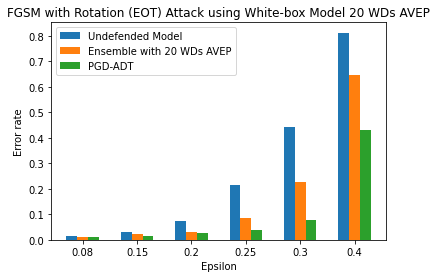

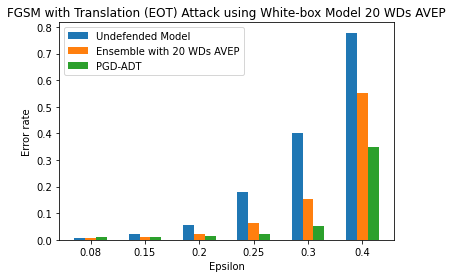

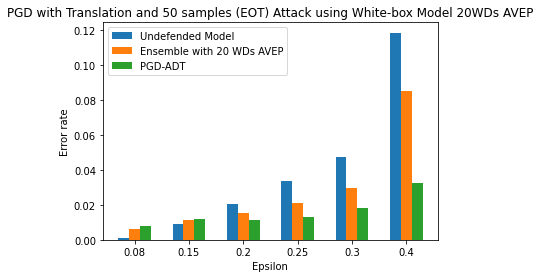

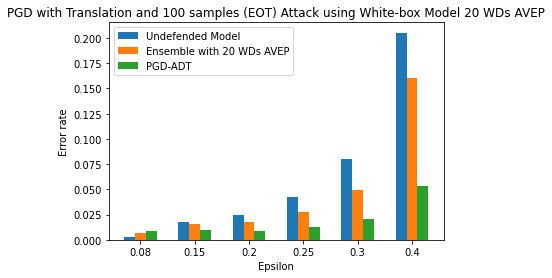

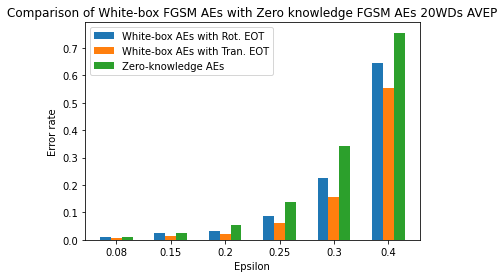

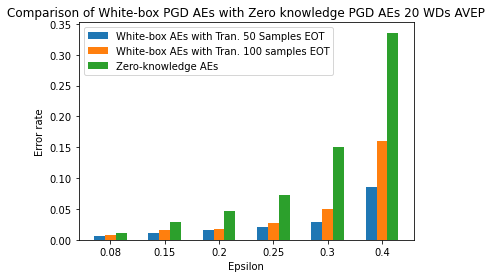

C:\Users\hezek\.conda\envs\athena\lib\site-packages\ipykernel_launcher.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator


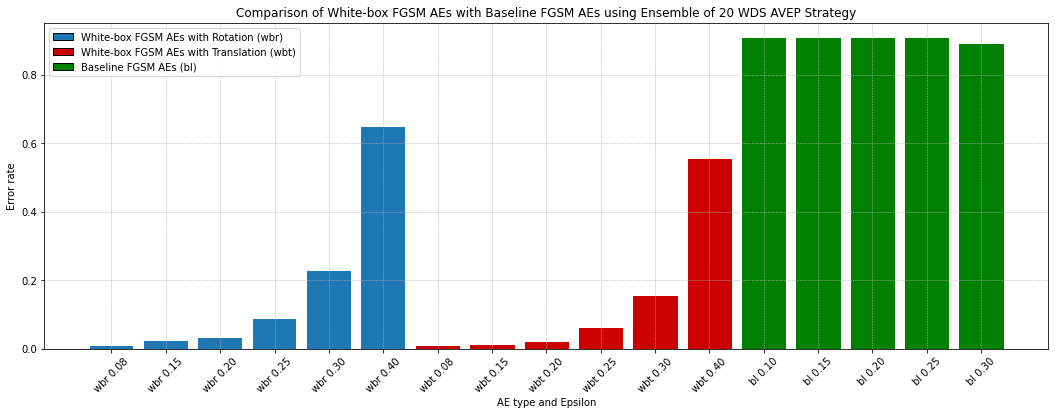

C:\Users\hezek\.conda\envs\athena\lib\site-packages\ipykernel_launcher.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator


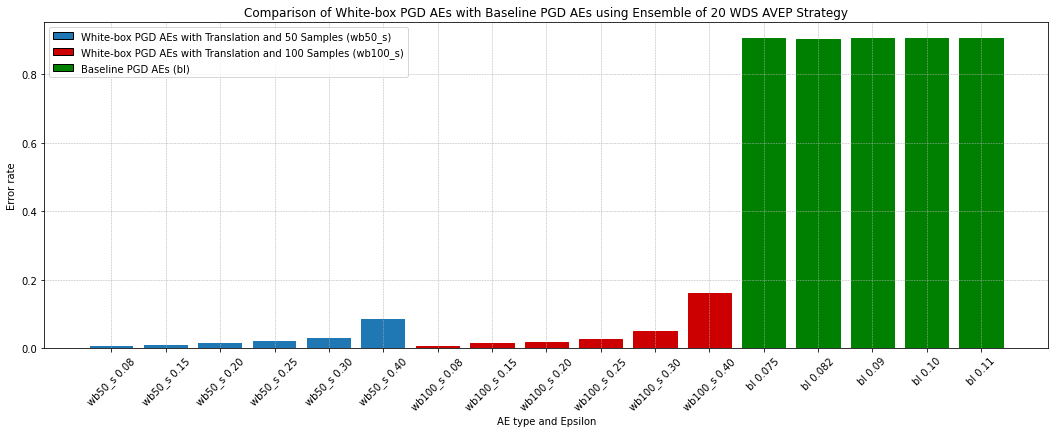

In [22]:
from matplotlib.patches import Patch
w = 0.2
x = [0.08, 0.15, 0.20, 0.25, 0.30, 0.40] #epsilon values for attack

# FGSM-White-box Attack with Rotation Setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_rot_20AVEP['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_Task2_rot_20AVEP['Ensemble'], w , label='Ensemble with 20 WDs AVEP')
plt.bar(bar3, FGSM_Task2_rot_20AVEP['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('FGSM with Rotation (EOT) Attack using White-box Model 20 WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# FGSM-White-box Attack with Translation setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_tran_20AVEP['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_Task2_tran_20AVEP['Ensemble'], w , label='Ensemble with 20 WDs AVEP')
plt.bar(bar3, FGSM_Task2_tran_20AVEP['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('FGSM with Translation (EOT) Attack using White-box Model 20 WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-White-box Attack with Translation and 50 num of samples setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_50_20AVEP['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_Task2_Tran_50_20AVEP['Ensemble'], w , label='Ensemble with 20 WDs AVEP')
plt.bar(bar3, PGD_Task2_Tran_50_20AVEP['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('PGD with Translation and 50 samples (EOT) Attack using White-box Model 20WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-White-box Attack with Translation and 100 num of samples setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_100_20AVEP['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_Task2_Tran_100_20AVEP['Ensemble'], w , label='Ensemble with 20 WDs AVEP')
plt.bar(bar3, PGD_Task2_Tran_100_20AVEP['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('PGD with Translation and 100 samples (EOT) Attack using White-box Model 20 WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# FGSM-Comparison of White-box AEs with Zero-Knowledge AEs
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_rot_20AVEP['Ensemble'], w , label='White-box AEs with Rot. EOT')
plt.bar(bar2, FGSM_Task2_tran_20AVEP['Ensemble'], w , label='White-box AEs with Tran. EOT')
plt.bar(bar3, FGSM_Task1_20AVEP['Ensemble'], w , label='Zero-knowledge AEs')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Comparison of White-box FGSM AEs with Zero knowledge FGSM AEs 20WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-Comparison of White-box AEs with Zero-Knowledge AEs
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_50_20AVEP['Ensemble'], w , label='White-box AEs with Tran. 50 Samples EOT')
plt.bar(bar2, PGD_Task2_Tran_100_20AVEP['Ensemble'], w , label='White-box AEs with Tran. 100 samples EOT')
plt.bar(bar3, PGD_Task1_20AVEP['Ensemble'], w , label='Zero-knowledge AEs')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Comparison of White-box PGD AEs with Zero knowledge PGD AEs 20 WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# w = 0.6
x_eps = ['wbr 0.08', 'wbr 0.15', 'wbr 0.20', 'wbr 0.25', 'wbr 0.30', 'wbr 0.40','wbt 0.08', 'wbt 0.15', 'wbt 0.20', 'wbt 0.25', 'wbt 0.30', 'wbt 0.40', 'bl 0.10', 'bl 0.15', 'bl 0.20', 'bl 0.25', 'bl 0.30']
new_data = {'Epsilon': x_eps, 'Error rate': FGSM_Task2_rot_20AVEP['Ensemble']+FGSM_Task2_tran_20AVEP['Ensemble']+FGSM_baseline_20AVEP['Ensemble']}

df = pd.DataFrame.from_dict(new_data)

legend_elements = [Patch(edgecolor='black',
                         label='White-box FGSM AEs with Rotation (wbr)'),Patch(facecolor='#CC0000',edgecolor='black',
                         label='White-box FGSM AEs with Translation (wbt)'), Patch(facecolor='green', edgecolor='black',
                         label='Baseline FGSM AEs (bl)')]

fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot(111)
ret = ax1.bar(df['Epsilon'], df['Error rate'])
ret[6].set_color('#CC0000')
ret[7].set_color('#CC0000')
ret[8].set_color('#CC0000')
ret[9].set_color('#CC0000')
ret[10].set_color('#CC0000')
ret[11].set_color('#CC0000')
ret[12].set_color('green')
ret[13].set_color('green')
ret[14].set_color('green')
ret[15].set_color('green')
ret[16].set_color('green')
ax1.xaxis.grid(linestyle= '--', linewidth=0.5)
ax1.yaxis.grid(linestyle= '--', linewidth=0.5)
ax1.legend(handles=legend_elements)
ax1.set_xticklabels(x_eps, rotation = 45)
ax1.set_xlabel('AE type and Epsilon')
ax1.set_ylabel('Error rate')
ax1.set_title('Comparison of White-box FGSM AEs with Baseline FGSM AEs using Ensemble of 20 WDS AVEP Strategy')
plt.show()

# PGD-Comparison of White-box AEs with Baseline AEs
x_eps = ['wb50_s 0.08', 'wb50_s 0.15', 'wb50_s 0.20', 'wb50_s 0.25', 'wb50_s 0.30', 'wb50_s 0.40','wb100_s 0.08', 'wb100_s 0.15', 'wb100_s 0.20', 'wb100_s 0.25', 'wb100_s 0.30', 'wb100_s 0.40', 'bl 0.075', 'bl 0.082', 'bl 0.09', 'bl 0.10', 'bl 0.11']
new_data = {'Epsilon': x_eps, 'Error rate': PGD_Task2_Tran_50_20AVEP['Ensemble']+PGD_Task2_Tran_100_20AVEP['Ensemble']+PGD_baseline_20AVEP['Ensemble']}

df = pd.DataFrame.from_dict(new_data)

legend_elements = [Patch(edgecolor='black',
                         label='White-box PGD AEs with Translation and 50 Samples (wb50_s)'),Patch(facecolor='#CC0000',edgecolor='black',
                         label='White-box PGD AEs with Translation and 100 Samples (wb100_s)'), Patch(facecolor='green', edgecolor='black',
                         label='Baseline PGD AEs (bl)')]

fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot(111)
ret = ax1.bar(df['Epsilon'], df['Error rate'])
ret[6].set_color('#CC0000')
ret[7].set_color('#CC0000')
ret[8].set_color('#CC0000')
ret[9].set_color('#CC0000')
ret[10].set_color('#CC0000')
ret[11].set_color('#CC0000')
ret[12].set_color('green')
ret[13].set_color('green')
ret[14].set_color('green')
ret[15].set_color('green')
ret[16].set_color('green')
ax1.xaxis.grid(linestyle= '--', linewidth=0.5)
ax1.yaxis.grid(linestyle= '--', linewidth=0.5)
ax1.legend(handles=legend_elements)
ax1.set_xticklabels(x_eps, rotation = 45)
ax1.set_xlabel('AE type and Epsilon')
ax1.set_ylabel('Error rate')
ax1.set_title('Comparison of White-box PGD AEs with Baseline PGD AEs using Ensemble of 20 WDS AVEP Strategy')
plt.show()

## Evaluation using 20 WDs with MV Ensemble Strategy

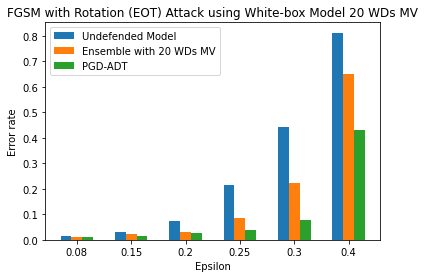

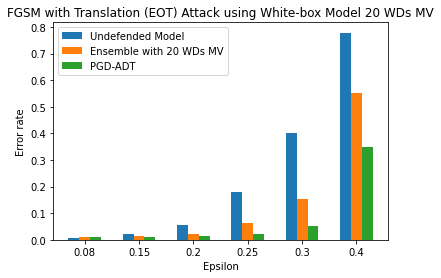

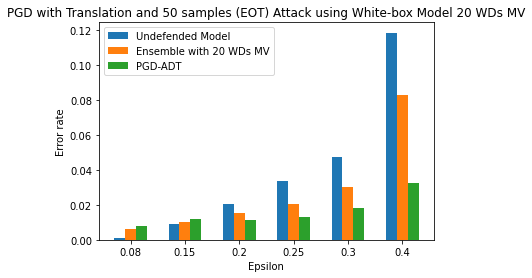

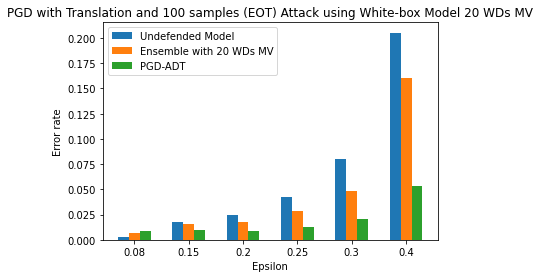

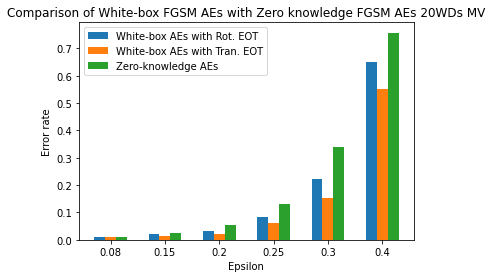

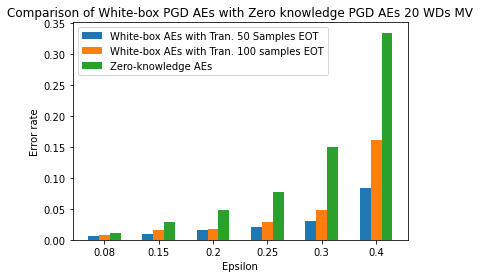

C:\Users\hezek\.conda\envs\athena\lib\site-packages\ipykernel_launcher.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator


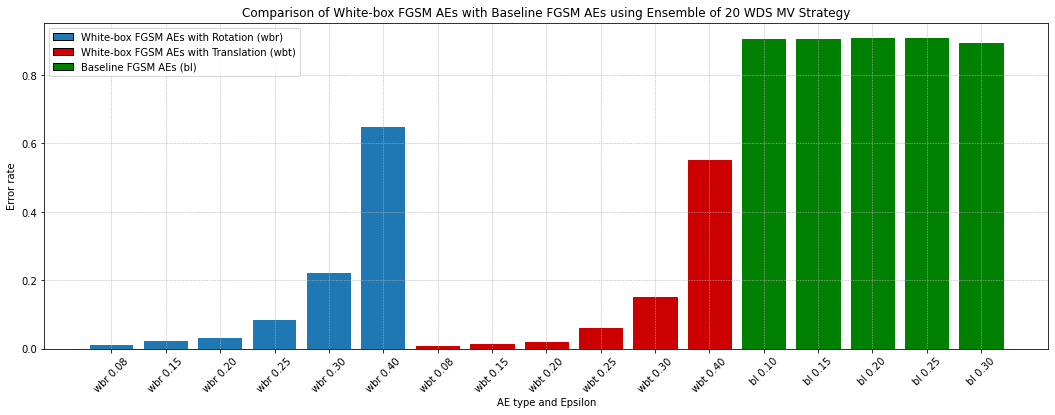

C:\Users\hezek\.conda\envs\athena\lib\site-packages\ipykernel_launcher.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator


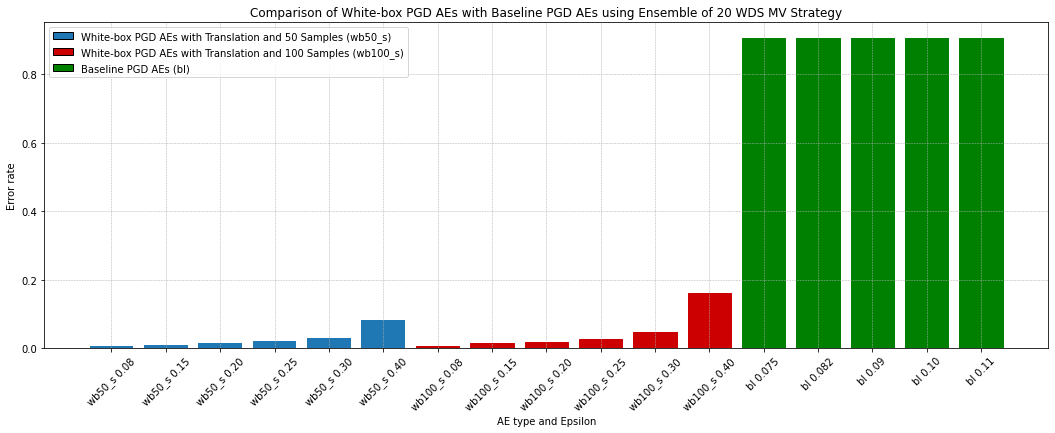

In [23]:
from matplotlib.patches import Patch
w = 0.2
x = [0.08, 0.15, 0.20, 0.25, 0.30, 0.40] #epsilon values for attack

# FGSM-White-box Attack with Rotation Setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_rot_20MV['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_Task2_rot_20MV['Ensemble'], w , label='Ensemble with 20 WDs MV')
plt.bar(bar3, FGSM_Task2_rot_20MV['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('FGSM with Rotation (EOT) Attack using White-box Model 20 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# FGSM-White-box Attack with Translation setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_tran_20MV['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_Task2_tran_20MV['Ensemble'], w , label='Ensemble with 20 WDs MV')
plt.bar(bar3, FGSM_Task2_tran_20MV['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('FGSM with Translation (EOT) Attack using White-box Model 20 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-White-box Attack with Translation and 50 num of samples setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_50_20MV['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_Task2_Tran_50_20MV['Ensemble'], w , label='Ensemble with 20 WDs MV')
plt.bar(bar3, PGD_Task2_Tran_50_20MV['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('PGD with Translation and 50 samples (EOT) Attack using White-box Model 20 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-White-box Attack with Translation and 100 num of samples setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_100_20MV['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_Task2_Tran_100_20MV['Ensemble'], w , label='Ensemble with 20 WDs MV')
plt.bar(bar3, PGD_Task2_Tran_100_20MV['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('PGD with Translation and 100 samples (EOT) Attack using White-box Model 20 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# FGSM-Comparison of White-box AEs with Zero-Knowledge AEs
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_rot_20MV['Ensemble'], w , label='White-box AEs with Rot. EOT')
plt.bar(bar2, FGSM_Task2_tran_20MV['Ensemble'], w , label='White-box AEs with Tran. EOT')
plt.bar(bar3, FGSM_Task1_20MV['Ensemble'], w , label='Zero-knowledge AEs')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Comparison of White-box FGSM AEs with Zero knowledge FGSM AEs 20WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-Comparison of White-box AEs with Zero-Knowledge AEs
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_50_20MV['Ensemble'], w , label='White-box AEs with Tran. 50 Samples EOT')
plt.bar(bar2, PGD_Task2_Tran_100_20MV['Ensemble'], w , label='White-box AEs with Tran. 100 samples EOT')
plt.bar(bar3, PGD_Task1_20MV['Ensemble'], w , label='Zero-knowledge AEs')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Comparison of White-box PGD AEs with Zero knowledge PGD AEs 20 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# w = 0.6
x_eps = ['wbr 0.08', 'wbr 0.15', 'wbr 0.20', 'wbr 0.25', 'wbr 0.30', 'wbr 0.40','wbt 0.08', 'wbt 0.15', 'wbt 0.20', 'wbt 0.25', 'wbt 0.30', 'wbt 0.40', 'bl 0.10', 'bl 0.15', 'bl 0.20', 'bl 0.25', 'bl 0.30']
new_data = {'Epsilon': x_eps, 'Error rate': FGSM_Task2_rot_20MV['Ensemble']+FGSM_Task2_tran_20MV['Ensemble']+FGSM_baseline_20MV['Ensemble']}

df = pd.DataFrame.from_dict(new_data)

legend_elements = [Patch(edgecolor='black',
                         label='White-box FGSM AEs with Rotation (wbr)'),Patch(facecolor='#CC0000',edgecolor='black',
                         label='White-box FGSM AEs with Translation (wbt)'), Patch(facecolor='green', edgecolor='black',
                         label='Baseline FGSM AEs (bl)')]

fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot(111)
ret = ax1.bar(df['Epsilon'], df['Error rate'])
ret[6].set_color('#CC0000')
ret[7].set_color('#CC0000')
ret[8].set_color('#CC0000')
ret[9].set_color('#CC0000')
ret[10].set_color('#CC0000')
ret[11].set_color('#CC0000')
ret[12].set_color('green')
ret[13].set_color('green')
ret[14].set_color('green')
ret[15].set_color('green')
ret[16].set_color('green')
ax1.xaxis.grid(linestyle= '--', linewidth=0.5)
ax1.yaxis.grid(linestyle= '--', linewidth=0.5)
ax1.legend(handles=legend_elements)
ax1.set_xticklabels(x_eps, rotation = 45)
ax1.set_xlabel('AE type and Epsilon')
ax1.set_ylabel('Error rate')
ax1.set_title('Comparison of White-box FGSM AEs with Baseline FGSM AEs using Ensemble of 20 WDS MV Strategy')
plt.show()

# PGD-Comparison of White-box AEs with Baseline AEs
x_eps = ['wb50_s 0.08', 'wb50_s 0.15', 'wb50_s 0.20', 'wb50_s 0.25', 'wb50_s 0.30', 'wb50_s 0.40','wb100_s 0.08', 'wb100_s 0.15', 'wb100_s 0.20', 'wb100_s 0.25', 'wb100_s 0.30', 'wb100_s 0.40', 'bl 0.075', 'bl 0.082', 'bl 0.09', 'bl 0.10', 'bl 0.11']
new_data = {'Epsilon': x_eps, 'Error rate': PGD_Task2_Tran_50_20MV['Ensemble']+PGD_Task2_Tran_100_20MV['Ensemble']+PGD_baseline_20MV['Ensemble']}

df = pd.DataFrame.from_dict(new_data)

legend_elements = [Patch(edgecolor='black',
                         label='White-box PGD AEs with Translation and 50 Samples (wb50_s)'),Patch(facecolor='#CC0000',edgecolor='black',
                         label='White-box PGD AEs with Translation and 100 Samples (wb100_s)'), Patch(facecolor='green', edgecolor='black',
                         label='Baseline PGD AEs (bl)')]

fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot(111)
ret = ax1.bar(df['Epsilon'], df['Error rate'])
ret[6].set_color('#CC0000')
ret[7].set_color('#CC0000')
ret[8].set_color('#CC0000')
ret[9].set_color('#CC0000')
ret[10].set_color('#CC0000')
ret[11].set_color('#CC0000')
ret[12].set_color('green')
ret[13].set_color('green')
ret[14].set_color('green')
ret[15].set_color('green')
ret[16].set_color('green')
ax1.xaxis.grid(linestyle= '--', linewidth=0.5)
ax1.yaxis.grid(linestyle= '--', linewidth=0.5)
ax1.legend(handles=legend_elements)
ax1.set_xticklabels(x_eps, rotation = 45)
ax1.set_xlabel('AE type and Epsilon')
ax1.set_ylabel('Error rate')
ax1.set_title('Comparison of White-box PGD AEs with Baseline PGD AEs using Ensemble of 20 WDS MV Strategy')
plt.show()


# Evaluation with 40 WDs

## With AVEP Strategy

In [24]:
FGSM_Task2_rot_40AVEP = {}
FGSM_Task2_tran_40AVEP = {}
PGD_Task2_Tran_50_40AVEP = {}
PGD_Task2_Tran_100_40AVEP = {}

FGSM_Task1_40AVEP = {}
PGD_Task1_40AVEP = {}

FGSM_baseline_40AVEP = {}
PGD_baseline_40AVEP = {}

FGSM_Task2_rot_40MV = {}
FGSM_Task2_tran_40MV = {}
PGD_Task2_Tran_50_40MV = {}
PGD_Task2_Tran_100_40MV = {}

FGSM_Task1_40MV = {}
PGD_Task1_40MV = {}

FGSM_baseline_40MV = {}
PGD_baseline_40MV = {}

In [26]:
# FGSM-white-box with Rotation
FGSM_Task2_rot_40AVEP['UM'] = task2_eval_40AVEP['UM'][:6]
FGSM_Task2_rot_40AVEP['Ensemble'] = task2_eval_40AVEP['Ensemble'][:6]
FGSM_Task2_rot_40AVEP['PGD-ADT'] = task2_eval_40AVEP['PGD-ADT'][:6]
print(FGSM_Task2_rot_40AVEP['UM'])
print(FGSM_Task2_rot_40AVEP['Ensemble'])
print(FGSM_Task2_rot_40AVEP['PGD-ADT'])

# FGSM-white-box with Translation
FGSM_Task2_tran_40AVEP['UM'] = task2_eval_40AVEP['UM'][6:12]
FGSM_Task2_tran_40AVEP['Ensemble'] = task2_eval_40AVEP['Ensemble'][6:12]
FGSM_Task2_tran_40AVEP['PGD-ADT'] = task2_eval_40AVEP['PGD-ADT'][6:12]
print(FGSM_Task2_tran_40AVEP['UM'])
print(FGSM_Task2_tran_40AVEP['Ensemble'])
print(FGSM_Task2_tran_40AVEP['PGD-ADT'])

# PGD-white-box with Translation at 50 Number of Samples
PGD_Task2_Tran_50_40AVEP['UM'] = task2_eval_40AVEP['UM'][12:18]
PGD_Task2_Tran_50_40AVEP['Ensemble'] = task2_eval_40AVEP['Ensemble'][12:18]
PGD_Task2_Tran_50_40AVEP['PGD-ADT'] = task2_eval_40AVEP['PGD-ADT'][12:18]
print(PGD_Task2_Tran_50_40AVEP['UM'])
print(PGD_Task2_Tran_50_40AVEP['Ensemble'])
print(PGD_Task2_Tran_50_40AVEP['PGD-ADT'])

# PGD-white-box with Translation at 100 Number of Samples
PGD_Task2_Tran_100_40AVEP['UM'] = task2_eval_40AVEP['UM'][18:]
PGD_Task2_Tran_100_40AVEP['Ensemble'] = task2_eval_40AVEP['Ensemble'][18:]
PGD_Task2_Tran_100_40AVEP['PGD-ADT'] = task2_eval_40AVEP['PGD-ADT'][18:]
print(PGD_Task2_Tran_100_40AVEP['UM'])
print(PGD_Task2_Tran_100_40AVEP['Ensemble'])
print(PGD_Task2_Tran_100_40AVEP['PGD-ADT'])

# FGSM-Zero-Knowledge 
FGSM_Task1_40AVEP['UM'] = task1_eval_40AVEP['UM'][:6]
FGSM_Task1_40AVEP['Ensemble'] = task1_eval_40AVEP['Ensemble'][:6]
FGSM_Task1_40AVEP['PGD-ADT'] = task1_eval_40AVEP['PGD-ADT'][:6]
print(FGSM_Task1_40AVEP['UM'])
print(FGSM_Task1_40AVEP['Ensemble'])
print(FGSM_Task1_40AVEP['PGD-ADT'])

# PGD-Zero-Knowledge 
PGD_Task1_40AVEP['UM'] = task1_eval_40AVEP['UM'][6:12]
PGD_Task1_40AVEP['Ensemble'] = task1_eval_40AVEP['Ensemble'][6:12]
PGD_Task1_40AVEP['PGD-ADT'] = task1_eval_40AVEP['PGD-ADT'][6:12]
print(PGD_Task1_40AVEP['UM'])
print(PGD_Task1_40AVEP['Ensemble'])
print(PGD_Task1_40AVEP['PGD-ADT'])

# FGSM-baseline AEs 
FGSM_baseline_40AVEP['UM'] = baseline_aes_eval_40AVEP['UM'][:5]
FGSM_baseline_40AVEP['Ensemble'] = baseline_aes_eval_40AVEP['Ensemble'][:5]
FGSM_baseline_40AVEP['PGD-ADT'] = baseline_aes_eval_40AVEP['PGD-ADT'][:5]
print(FGSM_baseline_40AVEP['UM'])
print(FGSM_baseline_40AVEP['Ensemble'])
print(FGSM_baseline_40AVEP['PGD-ADT'])

# PGD-Baseline AEs 
PGD_baseline_40AVEP['UM'] = baseline_aes_eval_40AVEP['UM'][5:]
PGD_baseline_40AVEP['Ensemble'] = baseline_aes_eval_40AVEP['Ensemble'][5:]
PGD_baseline_40AVEP['PGD-ADT'] = baseline_aes_eval_40AVEP['PGD-ADT'][5:]
print(PGD_baseline_40AVEP['UM'])
print(PGD_baseline_40AVEP['Ensemble'])
print(PGD_baseline_40AVEP['PGD-ADT'])


# FGSM-white-box with Rotation
FGSM_Task2_rot_40MV['UM'] = task2_eval_40MV['UM'][:6]
FGSM_Task2_rot_40MV['Ensemble'] = task2_eval_40MV['Ensemble'][:6]
FGSM_Task2_rot_40MV['PGD-ADT'] = task2_eval_40MV['PGD-ADT'][:6]
print(FGSM_Task2_rot_40MV['UM'])
print(FGSM_Task2_rot_40MV['Ensemble'])
print(FGSM_Task2_rot_40MV['PGD-ADT'])

# FGSM-white-box with Translation
FGSM_Task2_tran_40MV['UM'] = task2_eval_40MV['UM'][6:12]
FGSM_Task2_tran_40MV['Ensemble'] = task2_eval_40MV['Ensemble'][6:12]
FGSM_Task2_tran_40MV['PGD-ADT'] = task2_eval_40MV['PGD-ADT'][6:12]
print(FGSM_Task2_tran_40MV['UM'])
print(FGSM_Task2_tran_40MV['Ensemble'])
print(FGSM_Task2_tran_40MV['PGD-ADT'])

# PGD-white-box with Translation at 50 Number of Samples
PGD_Task2_Tran_50_40MV['UM'] = task2_eval_40MV['UM'][12:18]
PGD_Task2_Tran_50_40MV['Ensemble'] = task2_eval_40MV['Ensemble'][12:18]
PGD_Task2_Tran_50_40MV['PGD-ADT'] = task2_eval_40MV['PGD-ADT'][12:18]
print(PGD_Task2_Tran_50_20MV['UM'])
print(PGD_Task2_Tran_50_20MV['Ensemble'])
print(PGD_Task2_Tran_50_20MV['PGD-ADT'])

# PGD-white-box with Translation at 100 Number of Samples
PGD_Task2_Tran_100_40MV['UM'] = task2_eval_40MV['UM'][18:]
PGD_Task2_Tran_100_40MV['Ensemble'] = task2_eval_40MV['Ensemble'][18:]
PGD_Task2_Tran_100_40MV['PGD-ADT'] = task2_eval_40MV['PGD-ADT'][18:]
print(PGD_Task2_Tran_100_40MV['UM'])
print(PGD_Task2_Tran_100_40MV['Ensemble'])
print(PGD_Task2_Tran_100_40MV['PGD-ADT'])

# FGSM-Zero-Knowledge 
FGSM_Task1_40MV['UM'] = task1_eval_40MV['UM'][:6]
FGSM_Task1_40MV['Ensemble'] = task1_eval_40MV['Ensemble'][:6]
FGSM_Task1_40MV['PGD-ADT'] = task1_eval_40MV['PGD-ADT'][:6]
print(FGSM_Task1_40MV['UM'])
print(FGSM_Task1_40MV['Ensemble'])
print(FGSM_Task1_40MV['PGD-ADT'])

# PGD-Zero-Knowledge 
PGD_Task1_40MV['UM'] = task1_eval_40MV['UM'][6:12]
PGD_Task1_40MV['Ensemble'] = task1_eval_40MV['Ensemble'][6:12]
PGD_Task1_40MV['PGD-ADT'] = task1_eval_40MV['PGD-ADT'][6:12]
print(PGD_Task1_40MV['UM'])
print(PGD_Task1_40MV['Ensemble'])
print(PGD_Task1_40MV['PGD-ADT'])

# FGSM-baseline AEs 
FGSM_baseline_40MV['UM'] = baseline_aes_eval_40MV['UM'][:5]
FGSM_baseline_40MV['Ensemble'] = baseline_aes_eval_40MV['Ensemble'][:5]
FGSM_baseline_40MV['PGD-ADT'] = baseline_aes_eval_40MV['PGD-ADT'][:5]
print(FGSM_baseline_40MV['UM'])
print(FGSM_baseline_40MV['Ensemble'])
print(FGSM_baseline_40MV['PGD-ADT'])

# PGD-Baseline AEs 
PGD_baseline_40MV['UM'] = baseline_aes_eval_40MV['UM'][5:]
PGD_baseline_40MV['Ensemble'] = baseline_aes_eval_40MV['Ensemble'][5:]
PGD_baseline_40MV['PGD-ADT'] = baseline_aes_eval_40MV['PGD-ADT'][5:]
print(PGD_baseline_40MV['UM'])
print(PGD_baseline_40MV['Ensemble'])
print(PGD_baseline_40MV['PGD-ADT'])

[0.01314459049544995, 0.030333670374115267, 0.07381193124368049, 0.21638018200202225, 0.4408493427704752, 0.8119312436804853]
[0.008088978766430738, 0.019211324570273004, 0.029322548028311426, 0.06774519716885744, 0.1769464105156724, 0.6238624873609707]
[0.00910010111223458, 0.016177957532861477, 0.027300303336703743, 0.03842264914054601, 0.07684529828109202, 0.42972699696663297]
[0.006066734074823054, 0.021233569261880688, 0.056622851365015166, 0.18099089989888775, 0.40141557128412536, 0.7785642062689585]
[0.005055611729019211, 0.010111223458038422, 0.017189079878665317, 0.03943377148634985, 0.1102123356926188, 0.49342770475227504]
[0.00910010111223458, 0.011122345803842264, 0.015166835187057633, 0.022244691607684528, 0.0525783619817998, 0.3488372093023256]
[0.0010111223458038423, 0.00910010111223458, 0.020222446916076844, 0.033367037411526794, 0.047522750252780584, 0.11830131445904954]
[0.004044489383215369, 0.008088978766430738, 0.01314459049544995, 0.017189079878665317, 0.025278058

### Plots of AVEP with 40 WDs

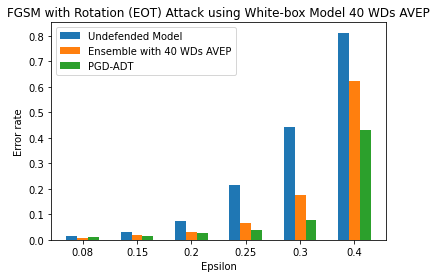

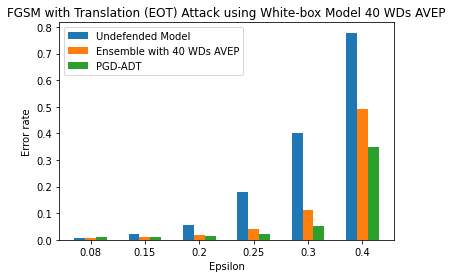

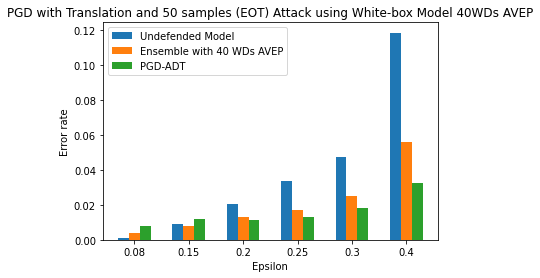

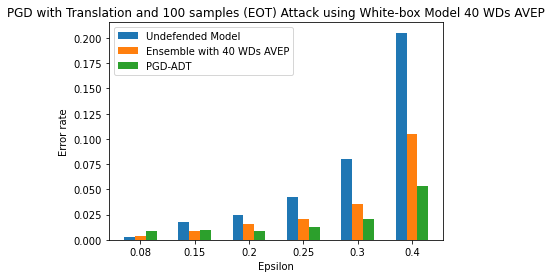

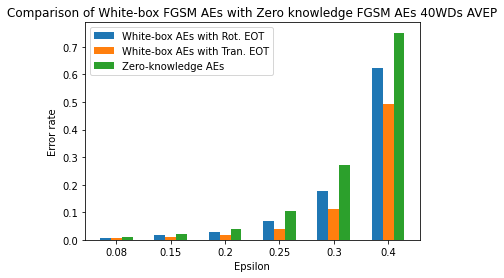

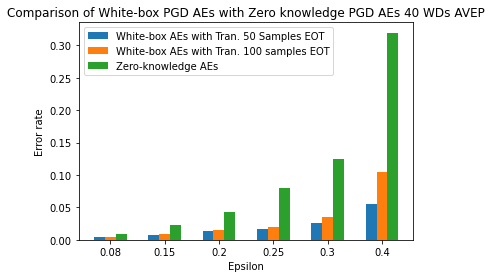

C:\Users\hezek\.conda\envs\athena\lib\site-packages\ipykernel_launcher.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator


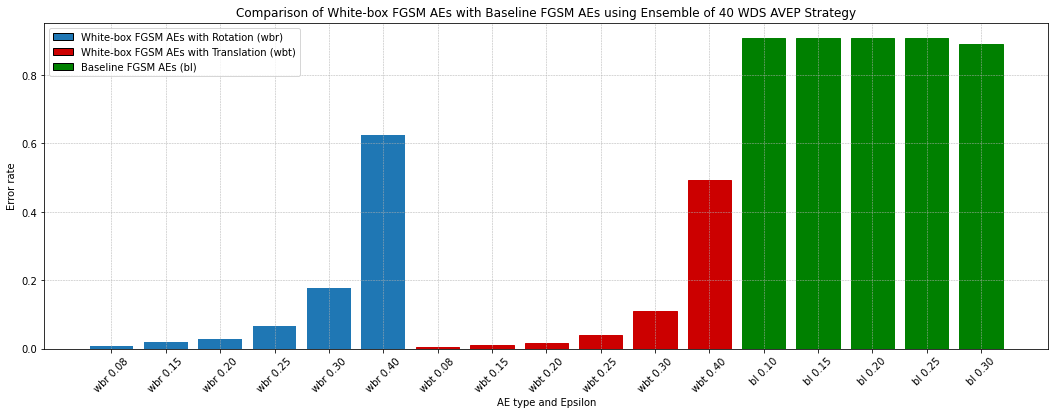

C:\Users\hezek\.conda\envs\athena\lib\site-packages\ipykernel_launcher.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator


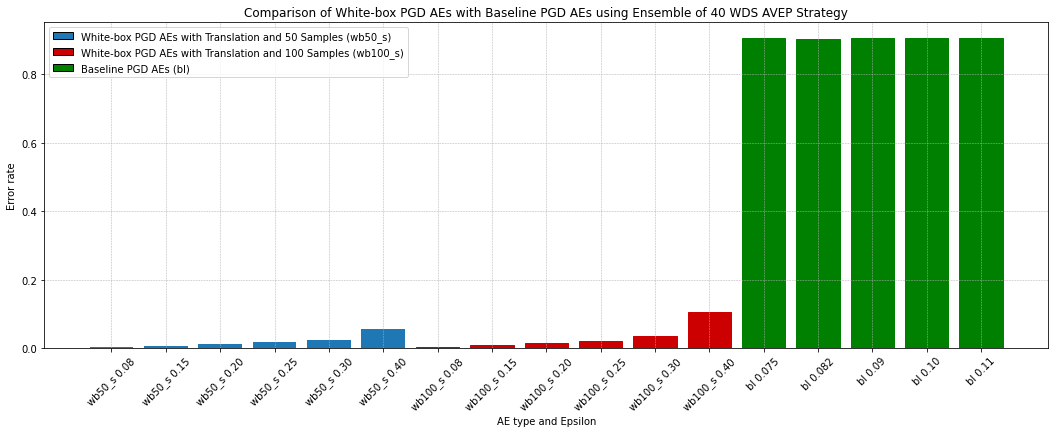

In [27]:
from matplotlib.patches import Patch
w = 0.2
x = [0.08, 0.15, 0.20, 0.25, 0.30, 0.40] #epsilon values for attack

# FGSM-White-box Attack with Rotation Setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_rot_40AVEP['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_Task2_rot_40AVEP['Ensemble'], w , label='Ensemble with 40 WDs AVEP')
plt.bar(bar3, FGSM_Task2_rot_40AVEP['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('FGSM with Rotation (EOT) Attack using White-box Model 40 WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# FGSM-White-box Attack with Translation setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_tran_40AVEP['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_Task2_tran_40AVEP['Ensemble'], w , label='Ensemble with 40 WDs AVEP')
plt.bar(bar3, FGSM_Task2_tran_40AVEP['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('FGSM with Translation (EOT) Attack using White-box Model 40 WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-White-box Attack with Translation and 50 num of samples setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_50_40AVEP['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_Task2_Tran_50_40AVEP['Ensemble'], w , label='Ensemble with 40 WDs AVEP')
plt.bar(bar3, PGD_Task2_Tran_50_40AVEP['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('PGD with Translation and 50 samples (EOT) Attack using White-box Model 40WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-White-box Attack with Translation and 100 num of samples setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_100_40AVEP['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_Task2_Tran_100_40AVEP['Ensemble'], w , label='Ensemble with 40 WDs AVEP')
plt.bar(bar3, PGD_Task2_Tran_100_40AVEP['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('PGD with Translation and 100 samples (EOT) Attack using White-box Model 40 WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# FGSM-Comparison of White-box AEs with Zero-Knowledge AEs
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_rot_40AVEP['Ensemble'], w , label='White-box AEs with Rot. EOT')
plt.bar(bar2, FGSM_Task2_tran_40AVEP['Ensemble'], w , label='White-box AEs with Tran. EOT')
plt.bar(bar3, FGSM_Task1_40AVEP['Ensemble'], w , label='Zero-knowledge AEs')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Comparison of White-box FGSM AEs with Zero knowledge FGSM AEs 40WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-Comparison of White-box AEs with Zero-Knowledge AEs
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_50_40AVEP['Ensemble'], w , label='White-box AEs with Tran. 50 Samples EOT')
plt.bar(bar2, PGD_Task2_Tran_100_40AVEP['Ensemble'], w , label='White-box AEs with Tran. 100 samples EOT')
plt.bar(bar3, PGD_Task1_40AVEP['Ensemble'], w , label='Zero-knowledge AEs')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Comparison of White-box PGD AEs with Zero knowledge PGD AEs 40 WDs AVEP')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# w = 0.6
x_eps = ['wbr 0.08', 'wbr 0.15', 'wbr 0.20', 'wbr 0.25', 'wbr 0.30', 'wbr 0.40','wbt 0.08', 'wbt 0.15', 'wbt 0.20', 'wbt 0.25', 'wbt 0.30', 'wbt 0.40', 'bl 0.10', 'bl 0.15', 'bl 0.20', 'bl 0.25', 'bl 0.30']
new_data = {'Epsilon': x_eps, 'Error rate': FGSM_Task2_rot_40AVEP['Ensemble']+FGSM_Task2_tran_40AVEP['Ensemble']+FGSM_baseline_40AVEP['Ensemble']}

df = pd.DataFrame.from_dict(new_data)

legend_elements = [Patch(edgecolor='black',
                         label='White-box FGSM AEs with Rotation (wbr)'),Patch(facecolor='#CC0000',edgecolor='black',
                         label='White-box FGSM AEs with Translation (wbt)'), Patch(facecolor='green', edgecolor='black',
                         label='Baseline FGSM AEs (bl)')]

fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot(111)
ret = ax1.bar(df['Epsilon'], df['Error rate'])
ret[6].set_color('#CC0000')
ret[7].set_color('#CC0000')
ret[8].set_color('#CC0000')
ret[9].set_color('#CC0000')
ret[10].set_color('#CC0000')
ret[11].set_color('#CC0000')
ret[12].set_color('green')
ret[13].set_color('green')
ret[14].set_color('green')
ret[15].set_color('green')
ret[16].set_color('green')
ax1.xaxis.grid(linestyle= '--', linewidth=0.5)
ax1.yaxis.grid(linestyle= '--', linewidth=0.5)
ax1.legend(handles=legend_elements)
ax1.set_xticklabels(x_eps, rotation = 45)
ax1.set_xlabel('AE type and Epsilon')
ax1.set_ylabel('Error rate')
ax1.set_title('Comparison of White-box FGSM AEs with Baseline FGSM AEs using Ensemble of 40 WDS AVEP Strategy')
plt.show()

# PGD-Comparison of White-box AEs with Baseline AEs
x_eps = ['wb50_s 0.08', 'wb50_s 0.15', 'wb50_s 0.20', 'wb50_s 0.25', 'wb50_s 0.30', 'wb50_s 0.40','wb100_s 0.08', 'wb100_s 0.15', 'wb100_s 0.20', 'wb100_s 0.25', 'wb100_s 0.30', 'wb100_s 0.40', 'bl 0.075', 'bl 0.082', 'bl 0.09', 'bl 0.10', 'bl 0.11']
new_data = {'Epsilon': x_eps, 'Error rate': PGD_Task2_Tran_50_40AVEP['Ensemble']+PGD_Task2_Tran_100_40AVEP['Ensemble']+PGD_baseline_40AVEP['Ensemble']}

df = pd.DataFrame.from_dict(new_data)

legend_elements = [Patch(edgecolor='black',
                         label='White-box PGD AEs with Translation and 50 Samples (wb50_s)'),Patch(facecolor='#CC0000',edgecolor='black',
                         label='White-box PGD AEs with Translation and 100 Samples (wb100_s)'), Patch(facecolor='green', edgecolor='black',
                         label='Baseline PGD AEs (bl)')]

fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot(111)
ret = ax1.bar(df['Epsilon'], df['Error rate'])
ret[6].set_color('#CC0000')
ret[7].set_color('#CC0000')
ret[8].set_color('#CC0000')
ret[9].set_color('#CC0000')
ret[10].set_color('#CC0000')
ret[11].set_color('#CC0000')
ret[12].set_color('green')
ret[13].set_color('green')
ret[14].set_color('green')
ret[15].set_color('green')
ret[16].set_color('green')
ax1.xaxis.grid(linestyle= '--', linewidth=0.5)
ax1.yaxis.grid(linestyle= '--', linewidth=0.5)
ax1.legend(handles=legend_elements)
ax1.set_xticklabels(x_eps, rotation = 45)
ax1.set_xlabel('AE type and Epsilon')
ax1.set_ylabel('Error rate')
ax1.set_title('Comparison of White-box PGD AEs with Baseline PGD AEs using Ensemble of 40 WDS AVEP Strategy')
plt.show()

### Plots of Evaluation Using 40 WDs with MV Strategy

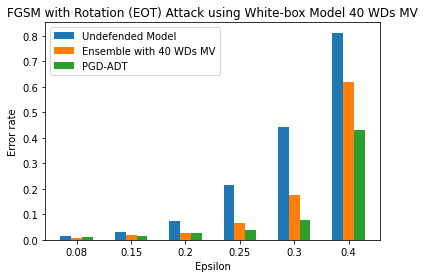

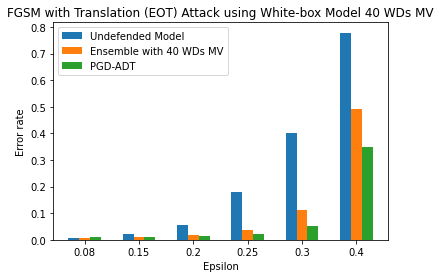

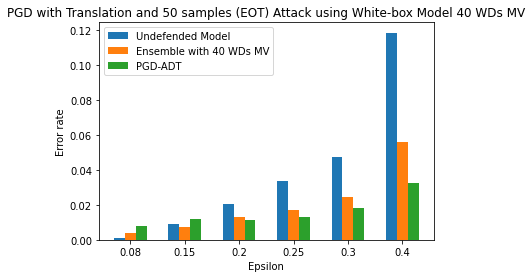

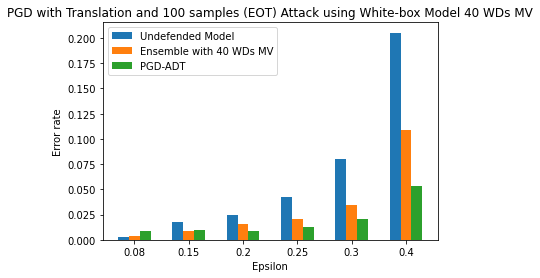

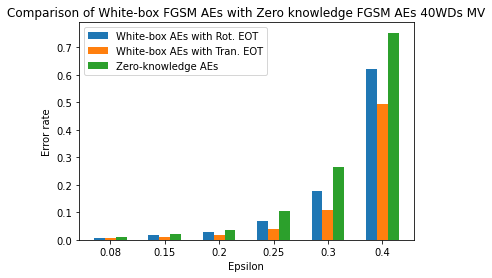

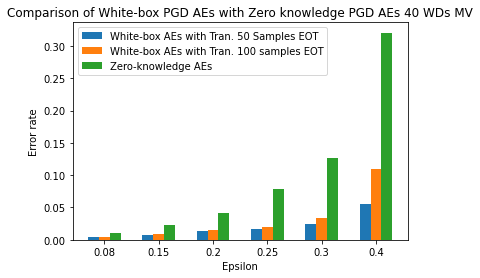

C:\Users\hezek\.conda\envs\athena\lib\site-packages\ipykernel_launcher.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator


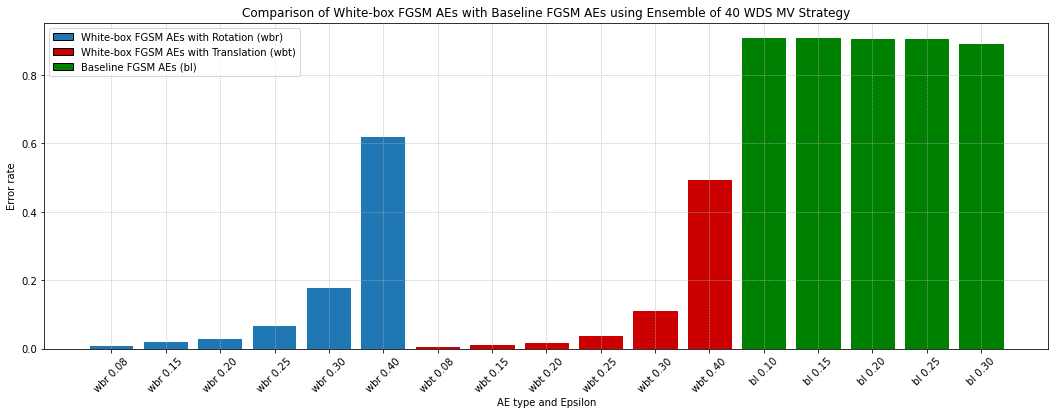

C:\Users\hezek\.conda\envs\athena\lib\site-packages\ipykernel_launcher.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator


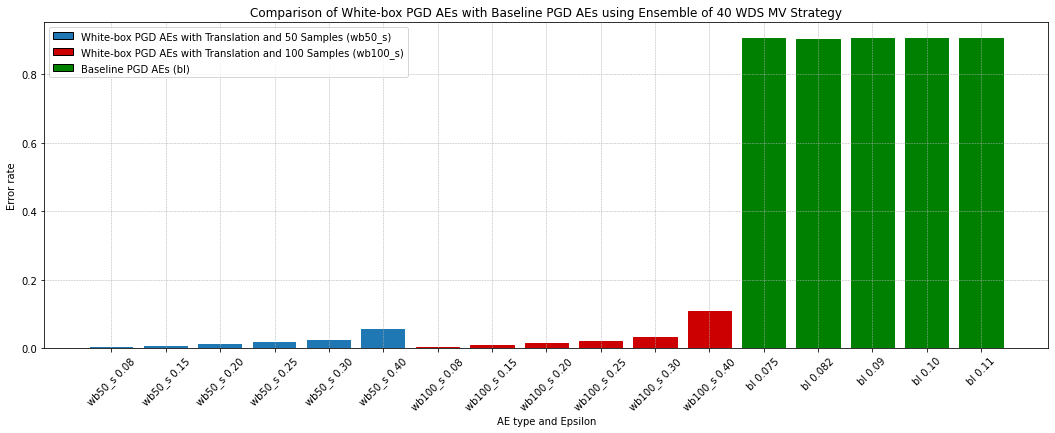

In [28]:
w = 0.2
x = [0.08, 0.15, 0.20, 0.25, 0.30, 0.40] #epsilon values for attack

# FGSM-White-box Attack with Rotation Setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_rot_40MV['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_Task2_rot_40MV['Ensemble'], w , label='Ensemble with 40 WDs MV')
plt.bar(bar3, FGSM_Task2_rot_40MV['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('FGSM with Rotation (EOT) Attack using White-box Model 40 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# FGSM-White-box Attack with Translation setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_tran_40MV['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_Task2_tran_40MV['Ensemble'], w , label='Ensemble with 40 WDs MV')
plt.bar(bar3, FGSM_Task2_tran_40MV['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('FGSM with Translation (EOT) Attack using White-box Model 40 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-White-box Attack with Translation and 50 num of samples setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_50_40MV['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_Task2_Tran_50_40MV['Ensemble'], w , label='Ensemble with 40 WDs MV')
plt.bar(bar3, PGD_Task2_Tran_50_40MV['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('PGD with Translation and 50 samples (EOT) Attack using White-box Model 40 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-White-box Attack with Translation and 100 num of samples setting in EOT
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_100_40MV['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_Task2_Tran_100_40MV['Ensemble'], w , label='Ensemble with 40 WDs MV')
plt.bar(bar3, PGD_Task2_Tran_100_40MV['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('PGD with Translation and 100 samples (EOT) Attack using White-box Model 40 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# FGSM-Comparison of White-box AEs with Zero-Knowledge AEs
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_Task2_rot_40MV['Ensemble'], w , label='White-box AEs with Rot. EOT')
plt.bar(bar2, FGSM_Task2_tran_40MV['Ensemble'], w , label='White-box AEs with Tran. EOT')
plt.bar(bar3, FGSM_Task1_40MV['Ensemble'], w , label='Zero-knowledge AEs')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Comparison of White-box FGSM AEs with Zero knowledge FGSM AEs 40WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# PGD-Comparison of White-box AEs with Zero-Knowledge AEs
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_Task2_Tran_50_40MV['Ensemble'], w , label='White-box AEs with Tran. 50 Samples EOT')
plt.bar(bar2, PGD_Task2_Tran_100_40MV['Ensemble'], w , label='White-box AEs with Tran. 100 samples EOT')
plt.bar(bar3, PGD_Task1_40MV['Ensemble'], w , label='Zero-knowledge AEs')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Comparison of White-box PGD AEs with Zero knowledge PGD AEs 40 WDs MV')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# w = 0.6
x_eps = ['wbr 0.08', 'wbr 0.15', 'wbr 0.20', 'wbr 0.25', 'wbr 0.30', 'wbr 0.40','wbt 0.08', 'wbt 0.15', 'wbt 0.20', 'wbt 0.25', 'wbt 0.30', 'wbt 0.40', 'bl 0.10', 'bl 0.15', 'bl 0.20', 'bl 0.25', 'bl 0.30']
new_data = {'Epsilon': x_eps, 'Error rate': FGSM_Task2_rot_40MV['Ensemble']+FGSM_Task2_tran_40MV['Ensemble']+FGSM_baseline_40MV['Ensemble']}

df = pd.DataFrame.from_dict(new_data)

legend_elements = [Patch(edgecolor='black',
                         label='White-box FGSM AEs with Rotation (wbr)'),Patch(facecolor='#CC0000',edgecolor='black',
                         label='White-box FGSM AEs with Translation (wbt)'), Patch(facecolor='green', edgecolor='black',
                         label='Baseline FGSM AEs (bl)')]

fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot(111)
ret = ax1.bar(df['Epsilon'], df['Error rate'])
ret[6].set_color('#CC0000')
ret[7].set_color('#CC0000')
ret[8].set_color('#CC0000')
ret[9].set_color('#CC0000')
ret[10].set_color('#CC0000')
ret[11].set_color('#CC0000')
ret[12].set_color('green')
ret[13].set_color('green')
ret[14].set_color('green')
ret[15].set_color('green')
ret[16].set_color('green')
ax1.xaxis.grid(linestyle= '--', linewidth=0.5)
ax1.yaxis.grid(linestyle= '--', linewidth=0.5)
ax1.legend(handles=legend_elements)
ax1.set_xticklabels(x_eps, rotation = 45)
ax1.set_xlabel('AE type and Epsilon')
ax1.set_ylabel('Error rate')
ax1.set_title('Comparison of White-box FGSM AEs with Baseline FGSM AEs using Ensemble of 40 WDS MV Strategy')
plt.show()

# PGD-Comparison of White-box AEs with Baseline AEs
x_eps = ['wb50_s 0.08', 'wb50_s 0.15', 'wb50_s 0.20', 'wb50_s 0.25', 'wb50_s 0.30', 'wb50_s 0.40','wb100_s 0.08', 'wb100_s 0.15', 'wb100_s 0.20', 'wb100_s 0.25', 'wb100_s 0.30', 'wb100_s 0.40', 'bl 0.075', 'bl 0.082', 'bl 0.09', 'bl 0.10', 'bl 0.11']
new_data = {'Epsilon': x_eps, 'Error rate': PGD_Task2_Tran_50_40MV['Ensemble']+PGD_Task2_Tran_100_40MV['Ensemble']+PGD_baseline_40MV['Ensemble']}

df = pd.DataFrame.from_dict(new_data)

legend_elements = [Patch(edgecolor='black',
                         label='White-box PGD AEs with Translation and 50 Samples (wb50_s)'),Patch(facecolor='#CC0000',edgecolor='black',
                         label='White-box PGD AEs with Translation and 100 Samples (wb100_s)'), Patch(facecolor='green', edgecolor='black',
                         label='Baseline PGD AEs (bl)')]

fig = plt.figure(figsize = (18, 6))
ax1 = plt.subplot(111)
ret = ax1.bar(df['Epsilon'], df['Error rate'])
ret[6].set_color('#CC0000')
ret[7].set_color('#CC0000')
ret[8].set_color('#CC0000')
ret[9].set_color('#CC0000')
ret[10].set_color('#CC0000')
ret[11].set_color('#CC0000')
ret[12].set_color('green')
ret[13].set_color('green')
ret[14].set_color('green')
ret[15].set_color('green')
ret[16].set_color('green')
ax1.xaxis.grid(linestyle= '--', linewidth=0.5)
ax1.yaxis.grid(linestyle= '--', linewidth=0.5)
ax1.legend(handles=legend_elements)
ax1.set_xticklabels(x_eps, rotation = 45)
ax1.set_xlabel('AE type and Epsilon')
ax1.set_ylabel('Error rate')
ax1.set_title('Comparison of White-box PGD AEs with Baseline PGD AEs using Ensemble of 40 WDS MV Strategy')
plt.show()